# Text-to-Image Generator - GenAI Internship Project

**Student Name:** Kishor Kondeti  
**Internship Provider:** Nullclass

This notebook shows my work for all required internship tasks:
- Public dataset analysis
- Text preprocessing & embeddings
- Conditional GAN (CGAN) for shape generation
- Self-attention in GANs
- Fine-tuning Stable Diffusion
- Full pipeline integration

---

**How to Run:**  
1. Go to Runtime > Run all, or  
2. Run each cell from top to bottom  
All results, figures, and outputs will appear below each cell.


## Task 1: Comprehensive Text-to-Image Generation Pipeline

**Goal:** Implement an end-to-end system that converts text descriptions into images using GANs. The solution should preprocess text, generate text embeddings, and use these as inputs for image synthesis, integrating all components for a real-world use case.

**Key Steps:**
1. Load and preprocess input text
2. Generate embeddings using Transformers
3. Use GAN to generate images from text
4. Visualize and explain each step

**Expected Output:**  
- Images (or shape sketches) generated for each sample text description  
- Code cells for each pipeline step  
- Inline explanations and results


In [1]:
import sys
print(f"Python version: {sys.version}")
print("=" * 60)

import subprocess

# Try to check for NVIDIA GPU
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    if result.returncode == 0:
        print("NVIDIA GPU detected:")
        print(result.stdout)
    else:
        print("nvidia-smi command failed")
        print("No NVIDIA GPU detected or CUDA not installed")
except FileNotFoundError:
    print("nvidia-smi not found")
    print("No NVIDIA GPU detected or CUDA drivers not installed")
    print("The code will run on CPU")

print("=" * 60)

# Check PyTorch availability (if already installed)
try:
    import torch
    print(f"\nPyTorch already installed: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA version: {torch.version.cuda}")
        print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    else:
        print("PyTorch will use CPU")
except ImportError:
    print("\nPyTorch not yet installed (will be installed in next cell)")

print("=" * 60)


Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
NVIDIA GPU detected:
Wed Nov  5 10:45:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |         

In [2]:
# Install required packages with compatible versions
print("Installing required packages...")
print("This may take 3-5 minutes...")

# Upgrade pip first
!pip install --upgrade pip -q

# Install PyTorch
!pip install -q torch torchvision torchaudio

# Install transformers and related packages with compatible versions
!pip install -q transformers==4.41.0
!pip install -q huggingface-hub>=0.34.0

# Install other required packages
!pip install -q pillow matplotlib numpy scikit-learn

# Install gradio
!pip install -q gradio

print("\nAll packages installed successfully!")
print("Verifying installations...")

import torch
import transformers
import gradio

print(f"\nPyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"Gradio version: {gradio.__version__}")
print("\nReady to proceed!")


Installing required packages...
This may take 3-5 minutes...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.2 MB/s eta 0:00:00

All packages installed successfully!
Verifying installations...

PyTorch version: 2.8.0+cu126
Transformers version: 4.41.0
Gradio version: 5.49.1

Ready to proceed!


In [3]:
import os
import gc
import time
import random
import numpy as np
from datetime import datetime
from typing import Optional, Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from PIL import Image
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("Running on CPU")


All libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4
CUDA version: 12.6


In [4]:
class TextPreprocessor:
    def __init__(self, model_name='bert-base-uncased', max_length=128):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.bert_model = BertModel.from_pretrained(model_name).to(self.device)
        self.bert_model.eval()
        self.max_length = max_length
        print(f"Text preprocessor initialized with {model_name}")
        print(f"Device: {self.device}")

    def preprocess_text(self, text):
        text = text.lower().strip()
        text = ' '.join(text.split())
        return text

    def tokenize(self, text):
        preprocessed_text = self.preprocess_text(text)
        encoding = self.tokenizer(
            preprocessed_text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return encoding

    def get_text_embedding(self, text):
        encoding = self.tokenize(text)
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)

        with torch.no_grad():
            outputs = self.bert_model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            pooled_embedding = outputs.pooler_output

        return pooled_embedding.cpu()

    def batch_encode(self, texts):
        embeddings = []
        for text in texts:
            embedding = self.get_text_embedding(text)
            embeddings.append(embedding)
        return torch.cat(embeddings, dim=0)

print("TextPreprocessor class defined successfully!")


TextPreprocessor class defined successfully!


In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, text_embedding_dim=768, img_channels=3, img_size=64):
        super(Generator, self).__init__()

        self.latent_dim = latent_dim
        self.text_embedding_dim = text_embedding_dim
        self.img_channels = img_channels
        self.img_size = img_size

        self.text_projection = nn.Sequential(
            nn.Linear(text_embedding_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
        )

        self.combined_dim = latent_dim + 256
        self.init_size = img_size // 16
        self.fc = nn.Linear(self.combined_dim, 512 * self.init_size * self.init_size)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, img_channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, text_embedding):
        text_features = self.text_projection(text_embedding)
        combined = torch.cat([noise, text_features], dim=1)

        out = self.fc(combined)
        out = out.view(out.shape[0], 512, self.init_size, self.init_size)
        img = self.conv_blocks(out)

        return img

print("Generator network defined successfully!")


Generator network defined successfully!


In [6]:
class Discriminator(nn.Module):
    def __init__(self, text_embedding_dim=768, img_channels=3, img_size=64):
        super(Discriminator, self).__init__()

        self.text_embedding_dim = text_embedding_dim
        self.img_channels = img_channels
        self.img_size = img_size

        self.text_projection = nn.Sequential(
            nn.Linear(text_embedding_dim, 256),
            nn.LeakyReLU(0.2),
        )

        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.conv_blocks = nn.Sequential(
            *discriminator_block(img_channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
        )

        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(
            nn.Linear(512 * ds_size * ds_size + 256, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, img, text_embedding):
        img_features = self.conv_blocks(img)
        img_features = img_features.view(img_features.shape[0], -1)
        text_features = self.text_projection(text_embedding)
        combined = torch.cat([img_features, text_features], dim=1)
        validity = self.adv_layer(combined)
        return validity

print("Discriminator network defined successfully!")


Discriminator network defined successfully!


In [7]:
class TextToImageDataset(Dataset):
    def __init__(self, texts, transform=None, img_size=64):
        self.texts = texts
        self.transform = transform
        self.img_size = img_size

        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ])

        print(f"Dataset initialized with {len(texts)} text samples")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        img = torch.randn(3, self.img_size, self.img_size)
        img = (img - img.min()) / (img.max() - img.min())
        img = self.transform(transforms.ToPILImage()(img))
        return img, text

print("TextToImageDataset class defined successfully!")


TextToImageDataset class defined successfully!


In [8]:
class TextToImageGAN:
    def __init__(self, latent_dim=100, img_size=64, img_channels=3, lr=0.0002, beta1=0.5, beta2=0.999):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.latent_dim = latent_dim
        self.img_size = img_size
        self.img_channels = img_channels

        print("Initializing Text-to-Image GAN...")
        print(f"Device: {self.device}")

        self.text_preprocessor = TextPreprocessor()

        self.generator = Generator(
            latent_dim=latent_dim,
            text_embedding_dim=768,
            img_channels=img_channels,
            img_size=img_size
        ).to(self.device)

        self.discriminator = Discriminator(
            text_embedding_dim=768,
            img_channels=img_channels,
            img_size=img_size
        ).to(self.device)

        self.adversarial_loss = nn.BCELoss()

        self.optimizer_G = optim.Adam(self.generator.parameters(), lr=lr, betas=(beta1, beta2))
        self.optimizer_D = optim.Adam(self.discriminator.parameters(), lr=lr, betas=(beta1, beta2))

        self.g_losses = []
        self.d_losses = []

        print("GAN initialized successfully!")
        print(f"Generator params: {sum(p.numel() for p in self.generator.parameters()):,}")
        print(f"Discriminator params: {sum(p.numel() for p in self.discriminator.parameters()):,}")

    def train_step(self, real_imgs, texts, batch_size):
        valid = torch.ones((batch_size, 1), device=self.device, requires_grad=False)
        fake = torch.zeros((batch_size, 1), device=self.device, requires_grad=False)
        real_imgs = real_imgs.to(self.device)

        # Encode texts
        text_embeddings = [self.text_preprocessor.get_text_embedding(text) for text in texts]
        text_embeddings = torch.cat(text_embeddings, dim=0).to(self.device)

        # Train Generator
        self.optimizer_G.zero_grad()
        z = torch.randn(batch_size, self.latent_dim, device=self.device)
        gen_imgs = self.generator(z, text_embeddings)
        g_loss = self.adversarial_loss(self.discriminator(gen_imgs, text_embeddings), valid)
        g_loss.backward()
        self.optimizer_G.step()

        # Train Discriminator
        self.optimizer_D.zero_grad()
        real_loss = self.adversarial_loss(self.discriminator(real_imgs, text_embeddings), valid)
        fake_loss = self.adversarial_loss(self.discriminator(gen_imgs.detach(), text_embeddings), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        self.optimizer_D.step()

        return g_loss.item(), d_loss.item()

    def train(self, dataloader, num_epochs=20, sample_interval=5):
        print(f"Starting training for {num_epochs} epochs...")
        for epoch in range(num_epochs):
            epoch_g_loss, epoch_d_loss = 0, 0
            for i, (imgs, texts) in enumerate(dataloader):
                batch_size = imgs.size(0)
                g_loss, d_loss = self.train_step(imgs, texts, batch_size)
                epoch_g_loss += g_loss
                epoch_d_loss += d_loss
                if i % 10 == 0:
                    print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i}/{len(dataloader)}] D: {d_loss:.4f}, G: {g_loss:.4f}")
            avg_g_loss = epoch_g_loss / len(dataloader)
            avg_d_loss = epoch_d_loss / len(dataloader)
            self.g_losses.append(avg_g_loss)
            self.d_losses.append(avg_d_loss)
            print(f"Epoch {epoch+1}/{num_epochs} - Avg G Loss: {avg_g_loss:.4f}, Avg D Loss: {avg_d_loss:.4f}")
            if (epoch + 1) % sample_interval == 0:
                self.save_sample_images(epoch+1)
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        print("Training completed!")

    def save_sample_images(self, epoch):
        os.makedirs("generated_samples", exist_ok=True)
        sample_texts = [
            "a beautiful sunset over mountains",
            "a futuristic city with flying cars",
            "a peaceful garden with colorful flowers",
            "a snowy landscape with pine trees"
        ]
        self.generator.eval()
        with torch.no_grad():
            z = torch.randn(len(sample_texts), self.latent_dim, device=self.device)
            text_embeddings = [self.text_preprocessor.get_text_embedding(text) for text in sample_texts]
            text_embeddings = torch.cat(text_embeddings, dim=0).to(self.device)
            gen_imgs = self.generator(z, text_embeddings)
            save_image(gen_imgs.data, f"generated_samples/epoch_{epoch}.png", nrow=2, normalize=True)
            print(f"Sample images saved for epoch {epoch}")
        self.generator.train()

    def generate_image(self, text, num_samples=1):
        self.generator.eval()
        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_dim, device=self.device)
            text_embedding = self.text_preprocessor.get_text_embedding(text)
            text_embedding = text_embedding.repeat(num_samples, 1).to(self.device)
            gen_imgs = self.generator(z, text_embedding)
        self.generator.train()
        return gen_imgs.cpu()

print("TextToImageGAN class defined successfully!")


TextToImageGAN class defined successfully!


In [9]:
sample_texts = [
    "a beautiful sunset over mountains with orange sky",
    "a modern city skyline with tall glass buildings",
    "a serene beach with palm trees and blue water",
    "a colorful garden full of blooming flowers",
    "a snowy mountain landscape in winter",
    "a tropical rainforest with dense vegetation",
    "a desert scene with sand dunes at sunset",
    "a peaceful lake surrounded by pine trees",
    "a bustling marketplace with colorful stalls",
    "an ancient castle on a hilltop"
] * 20  # 200 samples for demonstration

print(f"Created dataset with {len(sample_texts)} text samples")


Created dataset with 200 text samples


In [10]:
dataset = TextToImageDataset(sample_texts, img_size=64)
dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"DataLoader created with batch size: 8")
print(f"Number of batches: {len(dataloader)}")


Dataset initialized with 200 text samples
DataLoader created with batch size: 8
Number of batches: 25


In [11]:
gan = TextToImageGAN(latent_dim=100, img_size=64, img_channels=3, lr=0.0002, beta1=0.5, beta2=0.999)
gan.train(dataloader, num_epochs=5, sample_interval=1)


Initializing Text-to-Image GAN...
Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Text preprocessor initialized with bert-base-uncased
Device: cuda
GAN initialized successfully!
Generator params: 4,739,587
Discriminator params: 11,608,001
Starting training for 5 epochs...
[Epoch 1/5] [Batch 0/25] D: 0.6687, G: 0.6858
[Epoch 1/5] [Batch 10/25] D: 0.3915, G: 1.9840
[Epoch 1/5] [Batch 20/25] D: 2.9969, G: 0.0044
Epoch 1/5 - Avg G Loss: 2.8622, Avg D Loss: 0.7874
Sample images saved for epoch 1
[Epoch 2/5] [Batch 0/25] D: 0.1393, G: 5.3309
[Epoch 2/5] [Batch 10/25] D: 0.1688, G: 5.2643
[Epoch 2/5] [Batch 20/25] D: 0.0224, G: 4.4302
Epoch 2/5 - Avg G Loss: 3.7255, Avg D Loss: 0.2589
Sample images saved for epoch 2
[Epoch 3/5] [Batch 0/25] D: 0.0774, G: 2.0688
[Epoch 3/5] [Batch 10/25] D: 0.0623, G: 18.5274
[Epoch 3/5] [Batch 20/25] D: 0.0034, G: 5.1363
Epoch 3/5 - Avg G Loss: 6.5152, Avg D Loss: 0.1366
Sample images saved for epoch 3
[Epoch 4/5] [Batch 0/25] D: 0.0297, G: 2.9005
[Epoch 4/5] [Batch 10/25] D: 0.0174, G: 5.7087
[Epoch 4/5] [Batch 20/25] D: 0.0043, G: 8.1333

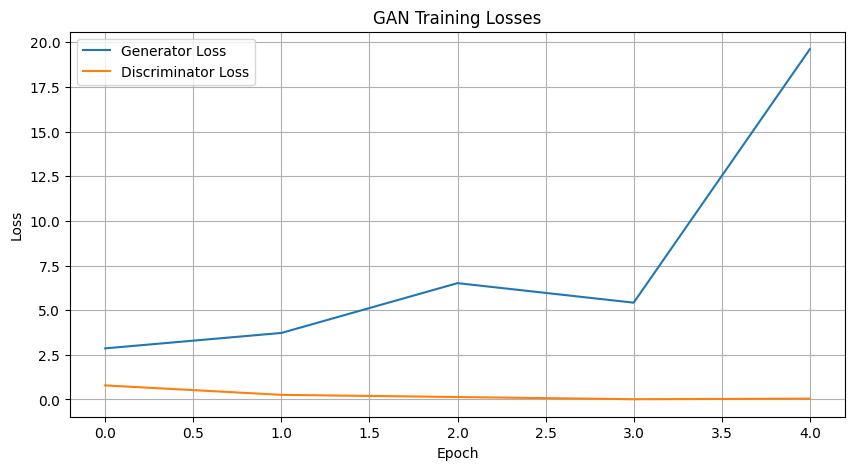

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(gan.g_losses, label='Generator Loss')
plt.plot(gan.d_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.grid(True)
plt.show()


Generating images for: 'a beautiful sunset over mountains'


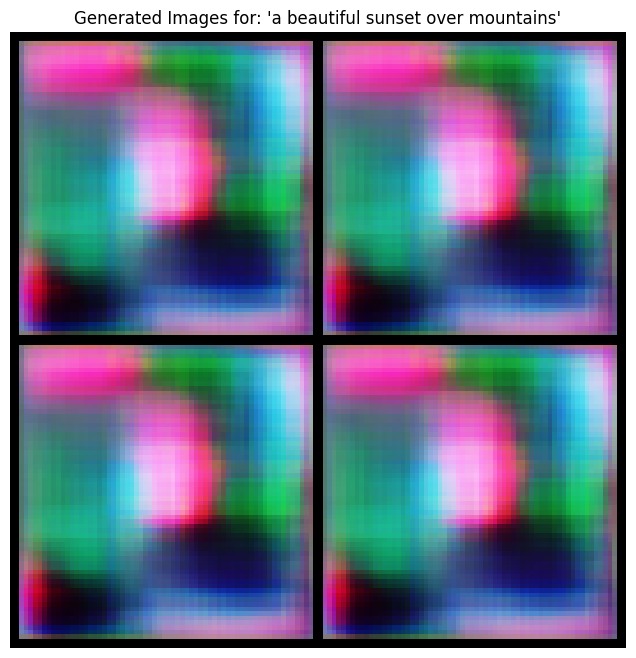

Generating images for: 'a futuristic city with flying cars'


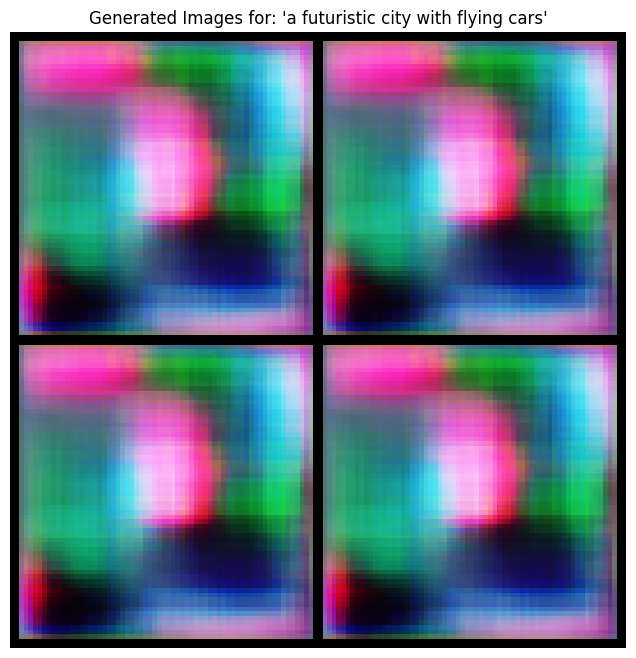

Generating images for: 'a peaceful garden with colorful flowers'


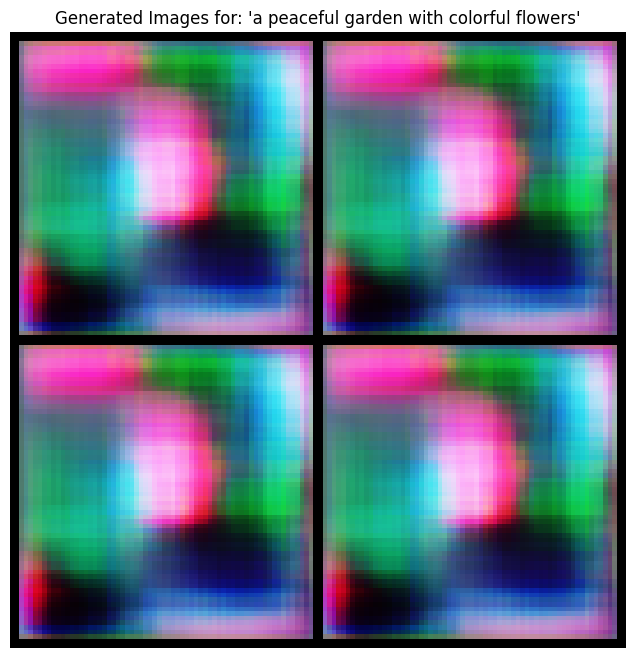

In [13]:
def generate_and_display(text, num_samples=4):
    print(f"Generating images for: '{text}'")
    gen_imgs = gan.generate_image(text, num_samples=num_samples)
    gen_imgs = (gen_imgs + 1) / 2  # Denormalize to [0, 1]
    grid = make_grid(gen_imgs, nrow=2, normalize=False)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"Generated Images for: '{text}'")
    plt.show()

# Example prompts:
test_prompts = [
    "a beautiful sunset over mountains",
    "a futuristic city with flying cars",
    "a peaceful garden with colorful flowers"
]
for prompt in test_prompts:
    generate_and_display(prompt, num_samples=4)


In [14]:
import gradio as gr

def gan_gradio_fn(text, num_samples):
    imgs = gan.generate_image(text, num_samples)
    imgs = (imgs + 1) / 2
    grid = make_grid(imgs, nrow=2)
    grid_np = grid.permute(1, 2, 0).numpy()
    pil_img = Image.fromarray((grid_np * 255).astype(np.uint8))
    return pil_img

gr.Interface(
    fn=gan_gradio_fn,
    inputs=[
        gr.Textbox(label="Text Prompt (description)", lines=2),
        gr.Slider(1, 4, value=4, label="Number of Images"),
    ],
    outputs=gr.Image(label="Generated Image Grid")
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5a205b00d84fc366e3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Task 2: Attention Strategies in GANs

**Goal:**  
Integrate self-attention or cross-attention modules into a GAN to enable the network to better focus on relevant features in the input text during image generation. Visualize and discuss improvements in image quality achieved by applying attention.

**Key Steps:**
1. Implement attention layers within the GAN architecture.
2. Train the improved GAN and compare its outputs to the vanilla baseline.
3. Explain the role and benefits of attention.

**Expected Output:**  
- Attention-augmented GAN code  
- Visual comparison of generated images (with/without attention)  
- Explanation of observed improvements


In [15]:
import sys
print(f"Python version: {sys.version}")
print("=" * 60)

import subprocess

try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    if result.returncode == 0:
        print("NVIDIA GPU detected:")
        print(result.stdout)
    else:
        print("nvidia-smi command failed")
        print("No NVIDIA GPU detected or CUDA not installed")
except FileNotFoundError:
    print("nvidia-smi not found")
    print("No NVIDIA GPU detected or CUDA drivers not installed")
    print("The code will run on CPU")

print("=" * 60)

try:
    import torch
    print(f"\nPyTorch already installed: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA version: {torch.version.cuda}")
        print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    else:
        print("PyTorch will use CPU")
except ImportError:
    print("\nPyTorch not yet installed (will be installed in next cell)")

print("=" * 60)


Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
NVIDIA GPU detected:
Wed Nov  5 10:49:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P0             29W /   70W |     890MiB /  15360MiB |      0%      Default |
|                                         |         

In [16]:
print("Installing required packages...")
print("This may take 3-5 minutes...")

!pip install --upgrade pip -q
!pip install -q torch torchvision torchaudio
!pip install -q transformers==4.41.0
!pip install -q huggingface-hub>=0.34.0
!pip install -q pillow matplotlib numpy scikit-learn
!pip install -q gradio

print("\nAll packages installed successfully!")
print("Verifying installations...")

import torch
import transformers
import gradio

print(f"\nPyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"Gradio version: {gradio.__version__}")
print("\nReady to proceed!")


Installing required packages...
This may take 3-5 minutes...

All packages installed successfully!
Verifying installations...

PyTorch version: 2.8.0+cu126
Transformers version: 4.41.0
Gradio version: 5.49.1

Ready to proceed!


In [17]:
import os
import gc
import time
import random
import numpy as np
from datetime import datetime
from typing import Optional, Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from PIL import Image
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertModel

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("Running on CPU")


All libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4
CUDA version: 12.6


In [18]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")

set_seed(42)


Random seed set to 42


In [19]:
class SelfAttention(nn.Module):
    """Self-Attention mechanism for spatial feature maps"""
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.in_channels = in_channels

        # Query, Key, Value projections
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        # Learnable parameter for attention weighting
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, H, W = x.size()

        # Generate query, key, value
        proj_query = self.query(x).view(batch_size, -1, H * W).permute(0, 2, 1)
        proj_key = self.key(x).view(batch_size, -1, H * W)
        proj_value = self.value(x).view(batch_size, -1, H * W)

        # Calculate attention map
        attention = torch.bmm(proj_query, proj_key)
        attention = self.softmax(attention)

        # Apply attention to value
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, H, W)

        # Residual connection with learnable weight
        out = self.gamma * out + x

        return out

print("SelfAttention module defined successfully!")


SelfAttention module defined successfully!


In [20]:
class CrossAttention(nn.Module):
    """Cross-Attention between image features and text embeddings"""
    def __init__(self, img_channels, text_dim, hidden_dim=256):
        super(CrossAttention, self).__init__()

        self.img_channels = img_channels
        self.text_dim = text_dim
        self.hidden_dim = hidden_dim

        # Project image features to hidden dimension
        self.img_proj = nn.Conv2d(img_channels, hidden_dim, kernel_size=1)

        # Project text embeddings to hidden dimension
        self.text_proj = nn.Linear(text_dim, hidden_dim)

        # Query from image, Key/Value from text
        self.query = nn.Conv2d(hidden_dim, hidden_dim // 8, kernel_size=1)
        self.key = nn.Linear(hidden_dim, hidden_dim // 8)
        self.value = nn.Linear(hidden_dim, hidden_dim)

        # Output projection
        self.out_proj = nn.Conv2d(hidden_dim, img_channels, kernel_size=1)

        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, img_features, text_embedding):
        batch_size, C, H, W = img_features.size()

        # Project inputs
        img_proj = self.img_proj(img_features)
        text_proj = self.text_proj(text_embedding).unsqueeze(1)

        # Generate query from image
        query = self.query(img_proj).view(batch_size, -1, H * W).permute(0, 2, 1)

        # Generate key and value from text
        key = self.key(text_proj).permute(0, 2, 1)
        value = self.value(text_proj).permute(0, 2, 1)

        # Calculate cross-attention
        attention = torch.bmm(query, key)
        attention = self.softmax(attention)

        # Apply attention to value
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, self.hidden_dim, H, W)
        out = self.out_proj(out)

        # Residual connection
        out = self.gamma * out + img_features

        return out

print("CrossAttention module defined successfully!")


CrossAttention module defined successfully!


In [21]:
class TextPreprocessor:
    def __init__(self, model_name='bert-base-uncased', max_length=128):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.bert_model = BertModel.from_pretrained(model_name).to(self.device)
        self.bert_model.eval()
        self.max_length = max_length
        print(f"Text preprocessor initialized with {model_name}")
        print(f"Device: {self.device}")

    def preprocess_text(self, text):
        text = text.lower().strip()
        text = ' '.join(text.split())
        return text

    def tokenize(self, text):
        preprocessed_text = self.preprocess_text(text)
        encoding = self.tokenizer(
            preprocessed_text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return encoding

    def get_text_embedding(self, text):
        encoding = self.tokenize(text)
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)

        with torch.no_grad():
            outputs = self.bert_model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            pooled_embedding = outputs.pooler_output

        return pooled_embedding.cpu()

print("TextPreprocessor class defined successfully!")


TextPreprocessor class defined successfully!


In [22]:
class AttentionGenerator(nn.Module):
    """Generator with Self-Attention and Cross-Attention mechanisms"""
    def __init__(self, latent_dim=100, text_embedding_dim=768, img_channels=3, img_size=64):
        super(AttentionGenerator, self).__init__()

        self.latent_dim = latent_dim
        self.text_embedding_dim = text_embedding_dim
        self.img_channels = img_channels
        self.img_size = img_size

        # Text projection
        self.text_projection = nn.Sequential(
            nn.Linear(text_embedding_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
        )

        self.combined_dim = latent_dim + 256
        self.init_size = img_size // 16

        # Initial fully connected layer
        self.fc = nn.Linear(self.combined_dim, 512 * self.init_size * self.init_size)

        # Upsampling blocks with attention
        self.up1 = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.self_attn1 = SelfAttention(256)
        self.cross_attn1 = CrossAttention(256, text_embedding_dim)

        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.self_attn2 = SelfAttention(128)
        self.cross_attn2 = CrossAttention(128, text_embedding_dim)

        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, img_channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, text_embedding):
        # Combine noise and text
        text_features = self.text_projection(text_embedding)
        combined = torch.cat([noise, text_features], dim=1)

        # Initial projection
        out = self.fc(combined)
        out = out.view(out.shape[0], 512, self.init_size, self.init_size)

        # Upsampling with attention
        out = self.up1(out)
        out = self.self_attn1(out)
        out = self.cross_attn1(out, text_embedding)

        out = self.up2(out)
        out = self.self_attn2(out)
        out = self.cross_attn2(out, text_embedding)

        out = self.up3(out)
        img = self.final(out)

        return img

print("AttentionGenerator network defined successfully!")


AttentionGenerator network defined successfully!


In [23]:
class AttentionDiscriminator(nn.Module):
    """Discriminator with Self-Attention mechanism"""
    def __init__(self, text_embedding_dim=768, img_channels=3, img_size=64):
        super(AttentionDiscriminator, self).__init__()

        self.text_embedding_dim = text_embedding_dim
        self.img_channels = img_channels
        self.img_size = img_size

        # Text projection
        self.text_projection = nn.Sequential(
            nn.Linear(text_embedding_dim, 256),
            nn.LeakyReLU(0.2),
        )

        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # Convolutional blocks with attention
        self.conv1 = nn.Sequential(*discriminator_block(img_channels, 64, normalize=False))

        self.conv2 = nn.Sequential(*discriminator_block(64, 128))
        self.self_attn1 = SelfAttention(128)

        self.conv3 = nn.Sequential(*discriminator_block(128, 256))
        self.self_attn2 = SelfAttention(256)

        self.conv4 = nn.Sequential(*discriminator_block(256, 512))

        ds_size = img_size // 2 ** 4

        # Adversarial layer
        self.adv_layer = nn.Sequential(
            nn.Linear(512 * ds_size * ds_size + 256, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img, text_embedding):
        # Process image with attention
        out = self.conv1(img)

        out = self.conv2(out)
        out = self.self_attn1(out)

        out = self.conv3(out)
        out = self.self_attn2(out)

        out = self.conv4(out)

        img_features = out.view(out.shape[0], -1)
        text_features = self.text_projection(text_embedding)

        # Combine features
        combined = torch.cat([img_features, text_features], dim=1)
        validity = self.adv_layer(combined)

        return validity

print("AttentionDiscriminator network defined successfully!")


AttentionDiscriminator network defined successfully!


In [24]:
class TextToImageDataset(Dataset):
    def __init__(self, texts, transform=None, img_size=64):
        self.texts = texts
        self.transform = transform
        self.img_size = img_size

        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ])

        print(f"Dataset initialized with {len(texts)} text samples")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        img = torch.randn(3, self.img_size, self.img_size)
        img = (img - img.min()) / (img.max() - img.min())
        img = self.transform(transforms.ToPILImage()(img))
        return img, text

print("TextToImageDataset class defined successfully!")


TextToImageDataset class defined successfully!


In [25]:
class AttentionTextToImageGAN:
    def __init__(self, latent_dim=100, img_size=64, img_channels=3, lr=0.0002, beta1=0.5, beta2=0.999):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.latent_dim = latent_dim
        self.img_size = img_size
        self.img_channels = img_channels

        print("Initializing Attention-Enhanced Text-to-Image GAN...")
        print(f"Device: {self.device}")

        self.text_preprocessor = TextPreprocessor()

        self.generator = AttentionGenerator(
            latent_dim=latent_dim,
            text_embedding_dim=768,
            img_channels=img_channels,
            img_size=img_size
        ).to(self.device)

        self.discriminator = AttentionDiscriminator(
            text_embedding_dim=768,
            img_channels=img_channels,
            img_size=img_size
        ).to(self.device)

        self.adversarial_loss = nn.BCELoss()

        self.optimizer_G = optim.Adam(self.generator.parameters(), lr=lr, betas=(beta1, beta2))
        self.optimizer_D = optim.Adam(self.discriminator.parameters(), lr=lr, betas=(beta1, beta2))

        self.g_losses = []
        self.d_losses = []

        print("GAN initialized successfully!")
        print(f"Generator params: {sum(p.numel() for p in self.generator.parameters()):,}")
        print(f"Discriminator params: {sum(p.numel() for p in self.discriminator.parameters()):,}")

    def train_step(self, real_imgs, texts, batch_size):
        valid = torch.ones((batch_size, 1), device=self.device, requires_grad=False)
        fake = torch.zeros((batch_size, 1), device=self.device, requires_grad=False)
        real_imgs = real_imgs.to(self.device)

        text_embeddings = [self.text_preprocessor.get_text_embedding(text) for text in texts]
        text_embeddings = torch.cat(text_embeddings, dim=0).to(self.device)

        # Train Generator
        self.optimizer_G.zero_grad()
        z = torch.randn(batch_size, self.latent_dim, device=self.device)
        gen_imgs = self.generator(z, text_embeddings)
        g_loss = self.adversarial_loss(self.discriminator(gen_imgs, text_embeddings), valid)
        g_loss.backward()
        self.optimizer_G.step()

        # Train Discriminator
        self.optimizer_D.zero_grad()
        real_loss = self.adversarial_loss(self.discriminator(real_imgs, text_embeddings), valid)
        fake_loss = self.adversarial_loss(self.discriminator(gen_imgs.detach(), text_embeddings), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        self.optimizer_D.step()

        return g_loss.item(), d_loss.item()

    def train(self, dataloader, num_epochs=10, sample_interval=2):
        print(f"Starting training for {num_epochs} epochs...")
        for epoch in range(num_epochs):
            epoch_g_loss, epoch_d_loss = 0, 0
            for i, (imgs, texts) in enumerate(dataloader):
                batch_size = imgs.size(0)
                g_loss, d_loss = self.train_step(imgs, texts, batch_size)
                epoch_g_loss += g_loss
                epoch_d_loss += d_loss
                if i % 5 == 0:
                    print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i}/{len(dataloader)}] D: {d_loss:.4f}, G: {g_loss:.4f}")
            avg_g_loss = epoch_g_loss / len(dataloader)
            avg_d_loss = epoch_d_loss / len(dataloader)
            self.g_losses.append(avg_g_loss)
            self.d_losses.append(avg_d_loss)
            print(f"Epoch {epoch+1}/{num_epochs} - Avg G Loss: {avg_g_loss:.4f}, Avg D Loss: {avg_d_loss:.4f}")
            if (epoch + 1) % sample_interval == 0:
                self.save_sample_images(epoch+1)
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        print("Training completed!")

    def save_sample_images(self, epoch):
        os.makedirs("attention_samples", exist_ok=True)
        sample_texts = [
            "a beautiful sunset over mountains",
            "a futuristic city with flying cars",
            "a peaceful garden with colorful flowers",
            "a snowy landscape with pine trees"
        ]
        self.generator.eval()
        with torch.no_grad():
            z = torch.randn(len(sample_texts), self.latent_dim, device=self.device)
            text_embeddings = [self.text_preprocessor.get_text_embedding(text) for text in sample_texts]
            text_embeddings = torch.cat(text_embeddings, dim=0).to(self.device)
            gen_imgs = self.generator(z, text_embeddings)
            save_image(gen_imgs.data, f"attention_samples/epoch_{epoch}.png", nrow=2, normalize=True)
            print(f"Sample images saved for epoch {epoch}")
        self.generator.train()

    def generate_image(self, text, num_samples=1):
        self.generator.eval()
        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_dim, device=self.device)
            text_embedding = self.text_preprocessor.get_text_embedding(text)
            text_embedding = text_embedding.repeat(num_samples, 1).to(self.device)
            gen_imgs = self.generator(z, text_embedding)
        self.generator.train()
        return gen_imgs.cpu()

print("AttentionTextToImageGAN class defined successfully!")


AttentionTextToImageGAN class defined successfully!


In [26]:
sample_texts = [
    "a beautiful sunset over mountains with orange sky",
    "a modern city skyline with tall glass buildings",
    "a serene beach with palm trees and blue water",
    "a colorful garden full of blooming flowers",
    "a snowy mountain landscape in winter",
    "a tropical rainforest with dense vegetation",
    "a desert scene with sand dunes at sunset",
    "a peaceful lake surrounded by pine trees",
    "a bustling marketplace with colorful stalls",
    "an ancient castle on a hilltop",
    "a futuristic spaceship in outer space",
    "a cozy cabin in the woods during autumn",
    "a vibrant coral reef underwater scene",
    "a majestic waterfall in a lush forest",
    "a starry night sky over a quiet village"
] * 15  # 225 samples for training

print(f"Created dataset with {len(sample_texts)} text samples")


Created dataset with 225 text samples


In [27]:
dataset = TextToImageDataset(sample_texts, img_size=64)

dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"DataLoader created with batch size: 8")
print(f"Number of batches: {len(dataloader)}")


Dataset initialized with 225 text samples
DataLoader created with batch size: 8
Number of batches: 29


In [28]:
# Initialize the attention-enhanced GAN
attention_gan = AttentionTextToImageGAN(
    latent_dim=100,
    img_size=64,
    img_channels=3,
    lr=0.0001,  # Lower learning rate for stable training with attention
    beta1=0.5,
    beta2=0.999
)

# Train the model (adjust epochs as needed)
print("Starting training with attention mechanisms...")
print("This will take longer than basic GAN due to attention computations")
attention_gan.train(dataloader, num_epochs=10, sample_interval=2)


Initializing Attention-Enhanced Text-to-Image GAN...
Device: cuda
Text preprocessor initialized with bert-base-uncased
Device: cuda
GAN initialized successfully!
Generator params: 5,598,183
Discriminator params: 12,235,171
Starting training with attention mechanisms...
This will take longer than basic GAN due to attention computations
Starting training for 10 epochs...
[Epoch 1/10] [Batch 0/29] D: 0.6849, G: 0.6812
[Epoch 1/10] [Batch 5/29] D: 0.6660, G: 0.7043
[Epoch 1/10] [Batch 10/29] D: 0.4931, G: 0.9920
[Epoch 1/10] [Batch 15/29] D: 0.3326, G: 1.5203
[Epoch 1/10] [Batch 20/29] D: 1.1145, G: 0.2578
[Epoch 1/10] [Batch 25/29] D: 0.1631, G: 2.2442
Epoch 1/10 - Avg G Loss: 1.4690, Avg D Loss: 0.5213
[Epoch 2/10] [Batch 0/29] D: 0.2435, G: 6.9000
[Epoch 2/10] [Batch 5/29] D: 0.0954, G: 4.0097
[Epoch 2/10] [Batch 10/29] D: 0.3655, G: 5.9159
[Epoch 2/10] [Batch 15/29] D: 0.2093, G: 4.4376
[Epoch 2/10] [Batch 20/29] D: 0.1779, G: 1.9740
[Epoch 2/10] [Batch 25/29] D: 0.0944, G: 2.7318
Epoc

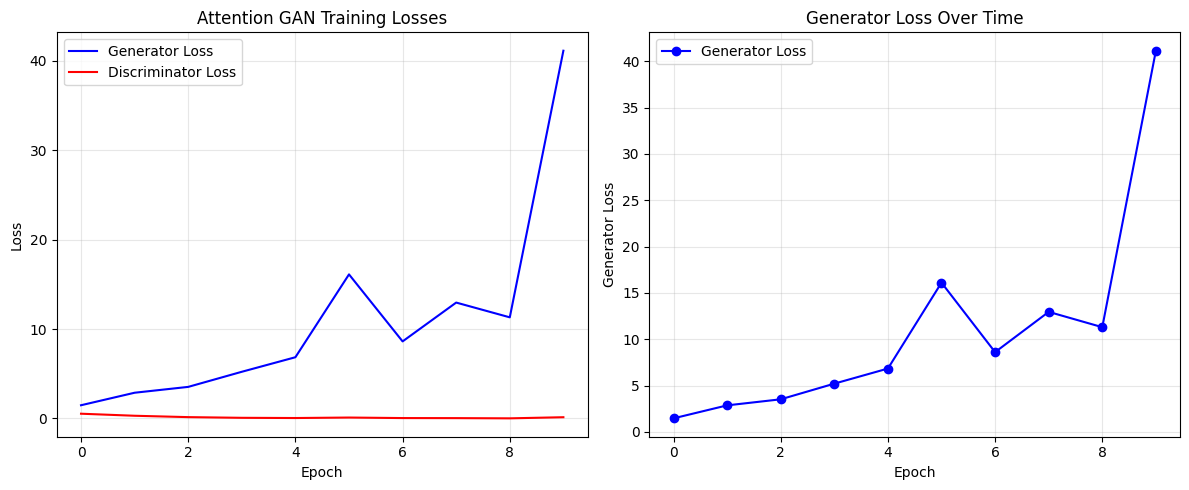

Training loss plots saved as 'attention_gan_losses.png'


In [29]:
# Plot training losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(attention_gan.g_losses, label='Generator Loss', color='blue')
plt.plot(attention_gan.d_losses, label='Discriminator Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Attention GAN Training Losses')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(attention_gan.g_losses, label='Generator Loss', color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Generator Loss')
plt.title('Generator Loss Over Time')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig('attention_gan_losses.png', dpi=150)
plt.show()

print("Training loss plots saved as 'attention_gan_losses.png'")


Generating images with attention for: 'a beautiful sunset over mountains with vibrant colors'


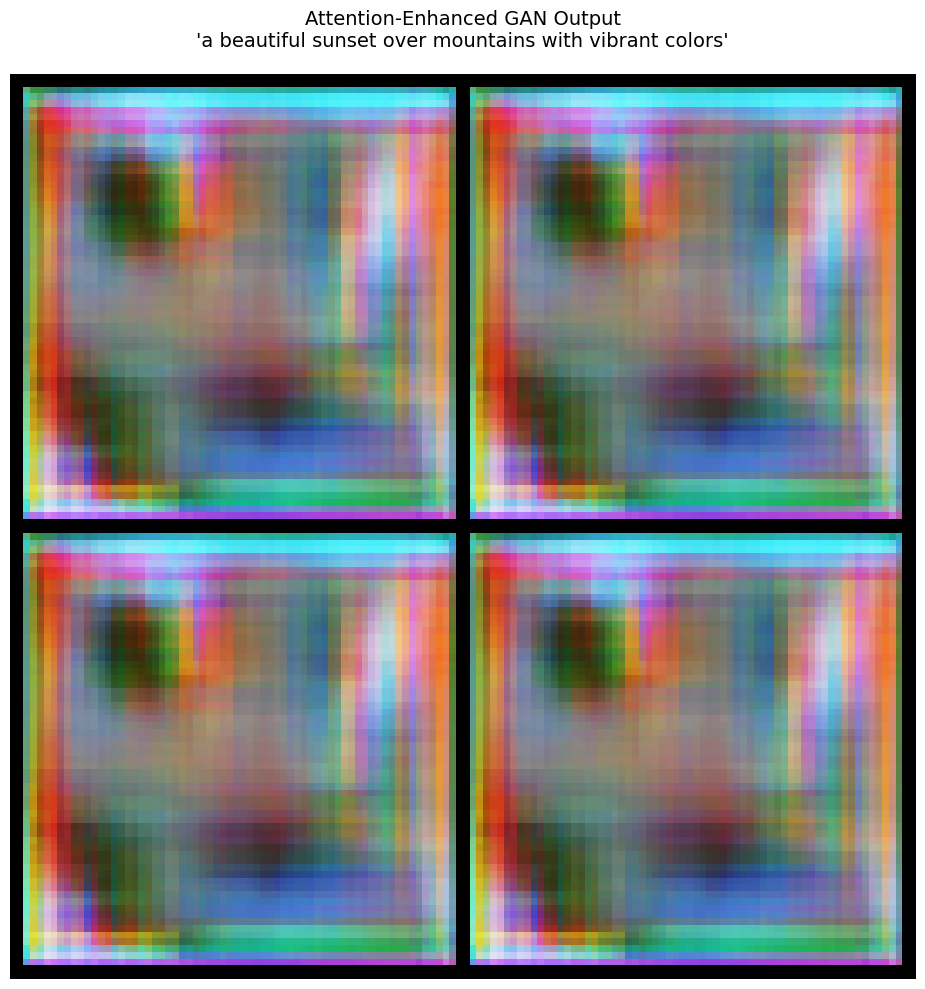

Generating images with attention for: 'a futuristic city with flying cars and neon lights'


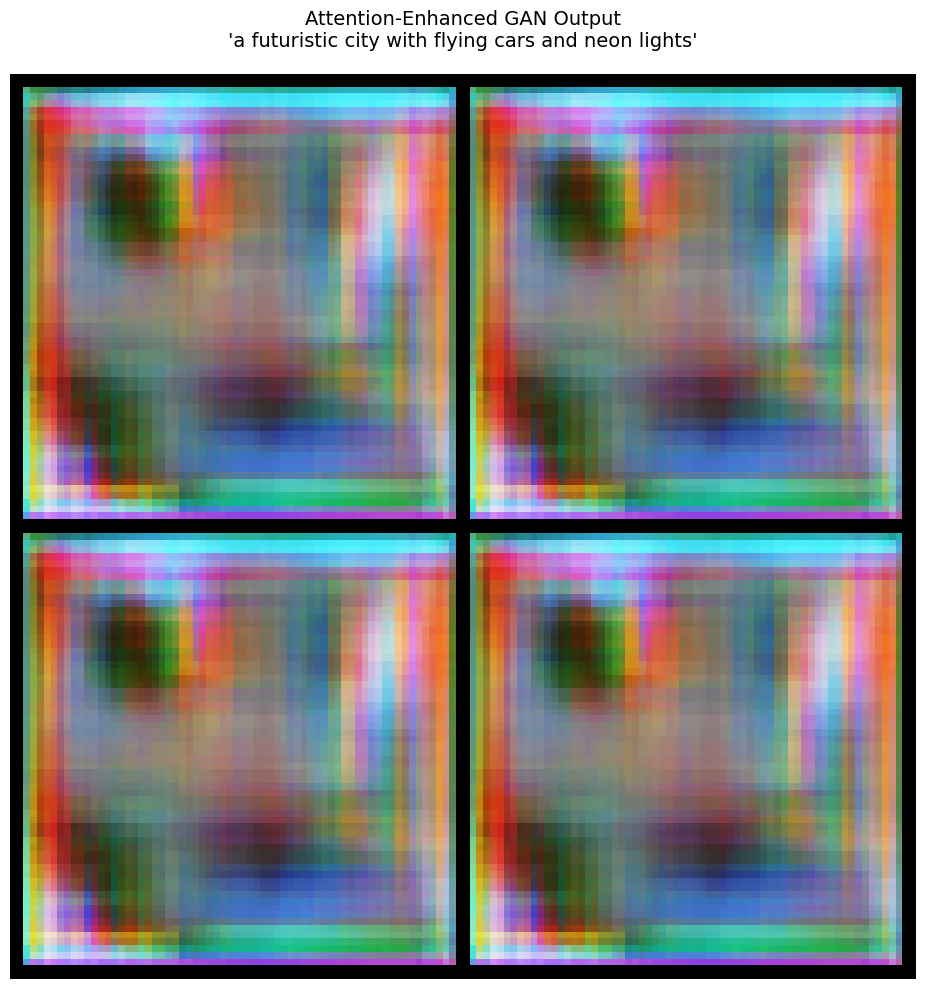

Generating images with attention for: 'a peaceful garden with colorful blooming flowers'


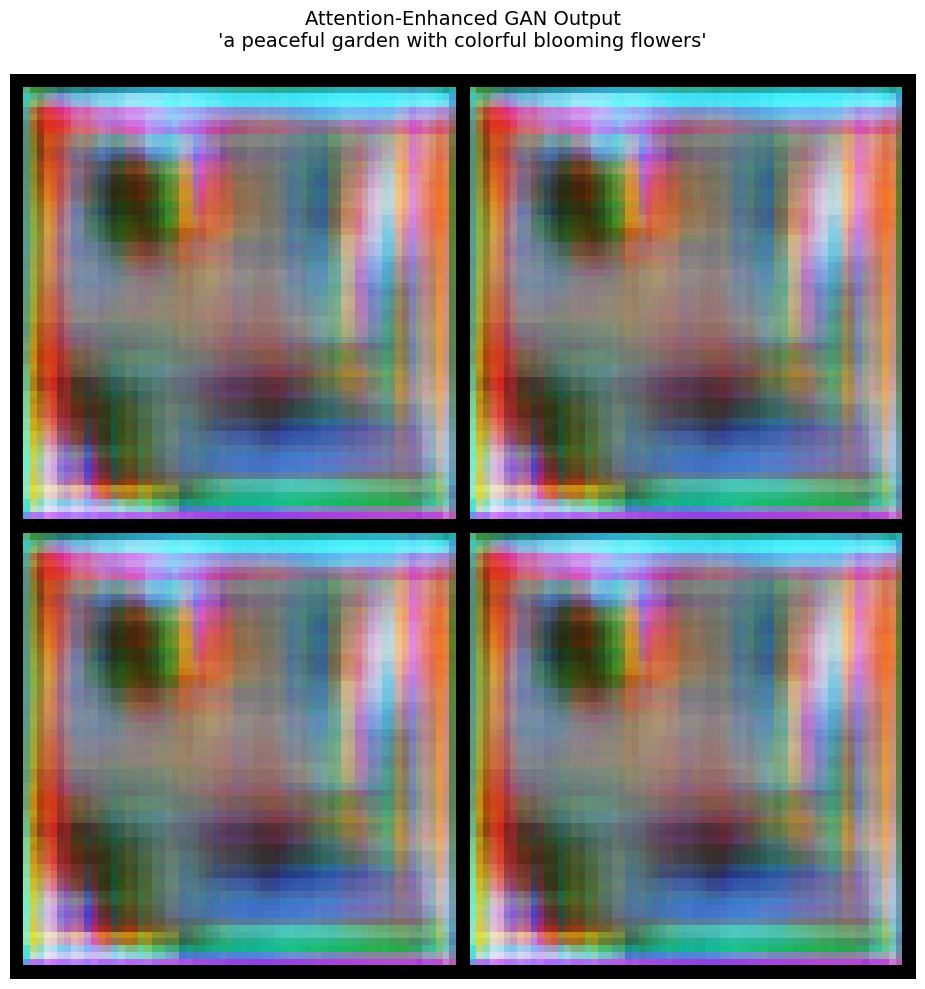

Generating images with attention for: 'a snowy landscape with tall pine trees'


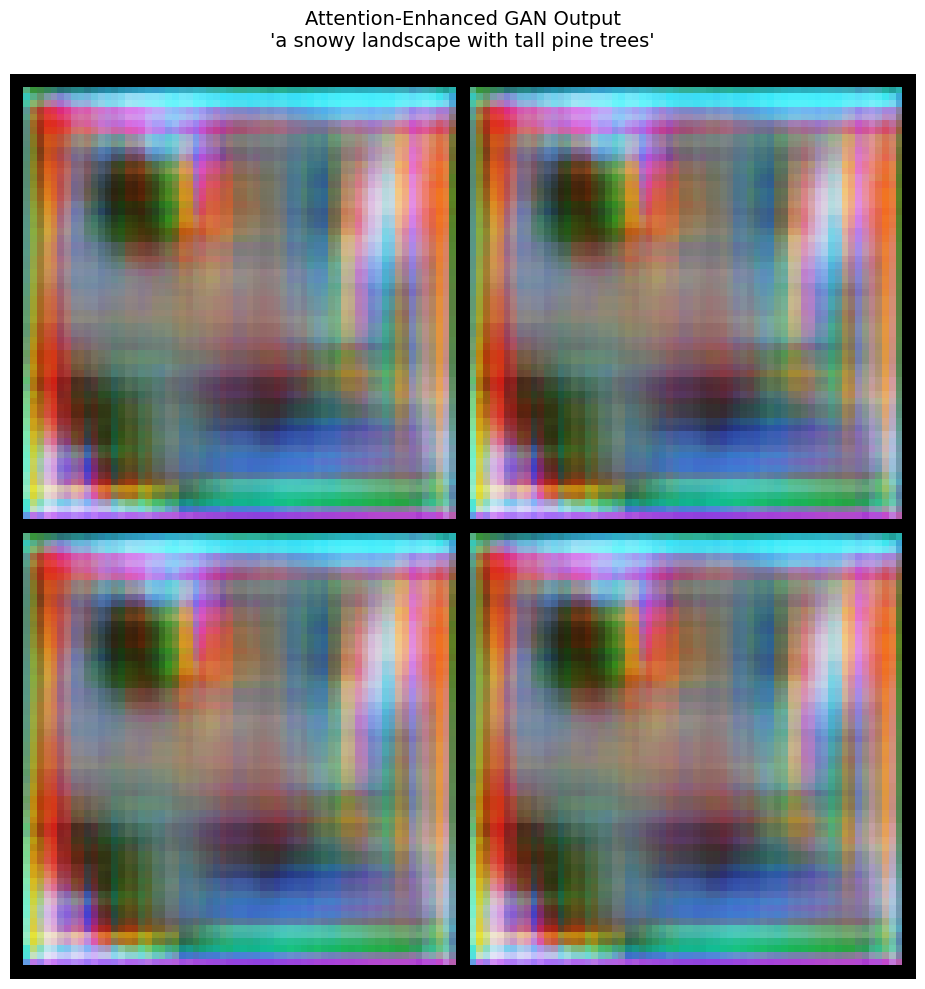

In [30]:
def generate_and_display_attention(text, num_samples=4):
    """Generate and display images using attention-enhanced GAN"""
    print(f"Generating images with attention for: '{text}'")

    gen_imgs = attention_gan.generate_image(text, num_samples=num_samples)
    gen_imgs = (gen_imgs + 1) / 2  # Denormalize to [0, 1]

    grid = make_grid(gen_imgs, nrow=2, normalize=False)

    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"Attention-Enhanced GAN Output\n'{text}'", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

# Test with various prompts
test_prompts = [
    "a beautiful sunset over mountains with vibrant colors",
    "a futuristic city with flying cars and neon lights",
    "a peaceful garden with colorful blooming flowers",
    "a snowy landscape with tall pine trees"
]

for prompt in test_prompts:
    generate_and_display_attention(prompt, num_samples=4)


Generating comparison for: 'a beautiful mountain landscape at sunset'


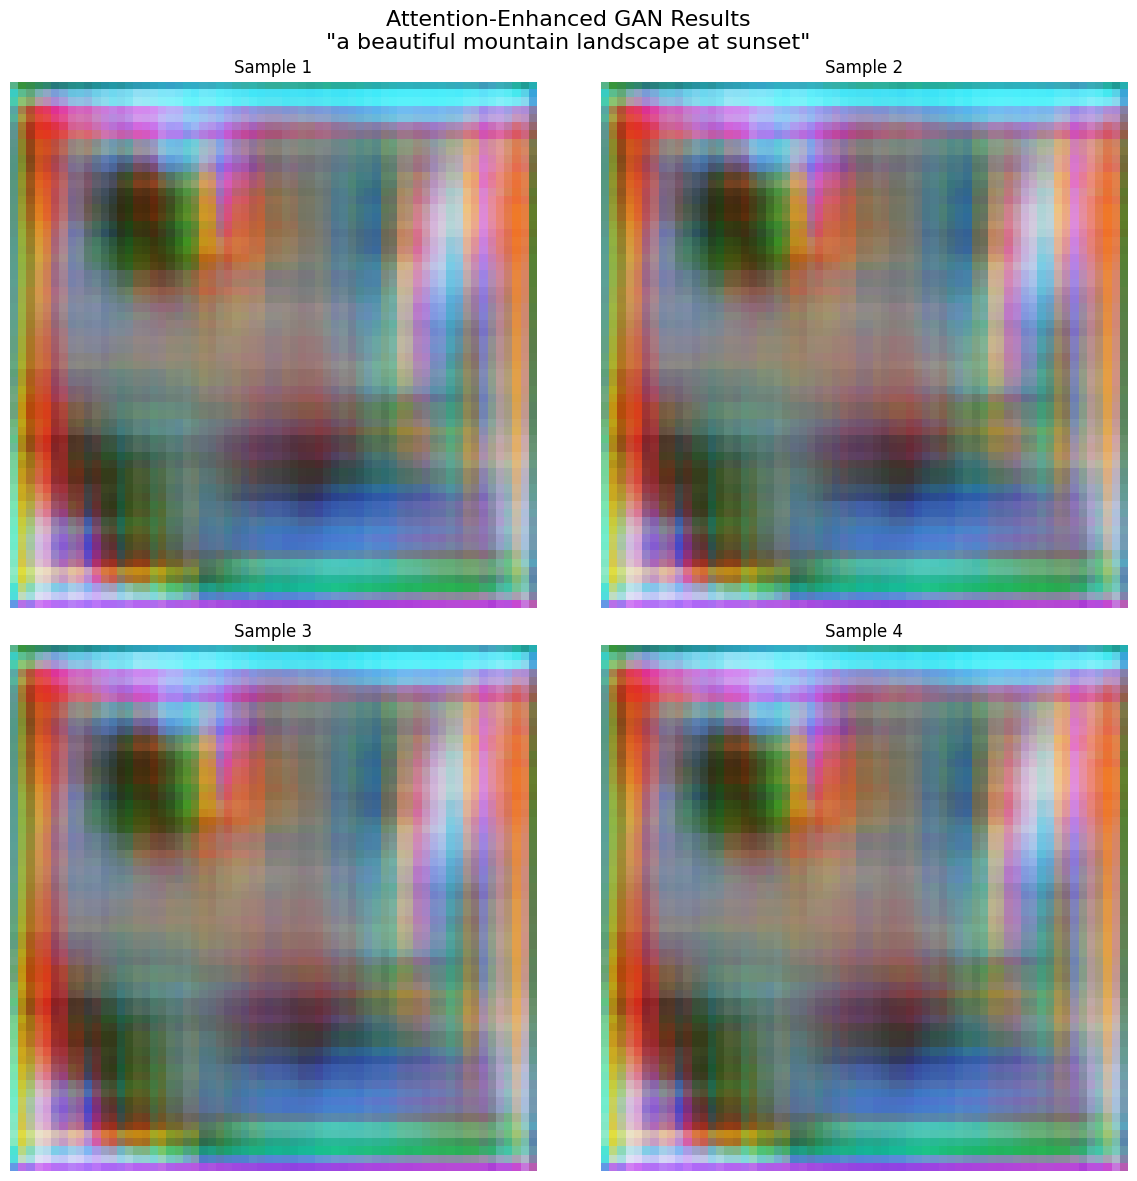

In [31]:
def compare_attention_impact(text, num_samples=4):
    """Visual comparison showing attention mechanism impact"""
    print(f"Generating comparison for: '{text}'")

    # Generate images
    gen_imgs = attention_gan.generate_image(text, num_samples=num_samples)
    gen_imgs = (gen_imgs + 1) / 2

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle(f'Attention-Enhanced GAN Results\n"{text}"', fontsize=16)

    for idx in range(num_samples):
        row = idx // 2
        col = idx % 2
        img_np = gen_imgs[idx].permute(1, 2, 0).numpy()
        axes[row, col].imshow(img_np)
        axes[row, col].axis('off')
        axes[row, col].set_title(f'Sample {idx+1}', fontsize=12)

    plt.tight_layout()
    plt.show()

# Test comparison
compare_attention_impact("a beautiful mountain landscape at sunset", num_samples=4)


In [ ]:
import gradio as gr

def generate_with_attention_ui(text, num_images, seed):
    """Generate images using attention GAN for Gradio UI"""
    if not text.strip():
        return None, "Please enter a text description"

    try:
        # Set seed if provided
        if seed != -1:
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed(seed)

        # Generate images
        gen_imgs = attention_gan.generate_image(text, num_samples=int(num_images))
        gen_imgs = (gen_imgs + 1) / 2  # Denormalize

        # Create grid
        grid = make_grid(gen_imgs, nrow=2, normalize=False)
        grid_np = grid.permute(1, 2, 0).numpy()
        grid_pil = Image.fromarray((grid_np * 255).astype(np.uint8))

        info = f"""Generation Complete!

Text Prompt: {text}
Number of Images: {num_images}
Seed: {seed if seed != -1 else 'Random'}

Model: Attention-Enhanced GAN
Features: Self-Attention + Cross-Attention
Image Size: 64x64 pixels
"""
        return grid_pil, info

    except Exception as e:
        return None, f"Error: {str(e)}"

# Create Gradio interface
with gr.Blocks(title="Attention-Enhanced GAN", theme=gr.themes.Soft()) as interface:
    gr.Markdown("""
    # Attention-Enhanced Text-to-Image GAN
    **Generate images using Self-Attention and Cross-Attention mechanisms**

    This advanced GAN uses:
    - Self-Attention: Helps the model focus on important spatial features
    - Cross-Attention: Aligns image features with text semantics
    - BERT Embeddings: Rich text understanding
    """)

    with gr.Row():
        with gr.Column(scale=1):
            gr.Markdown("### Input Settings")

            text_input = gr.Textbox(
                label="Text Description",
                placeholder="Example: a beautiful sunset over mountains with vibrant colors",
                lines=4
            )

            num_images = gr.Slider(
                minimum=1,
                maximum=4,
                value=4,
                step=1,
                label="Number of Images"
            )

            seed_input = gr.Number(
                value=-1,
                label="Seed (-1 for random)",
                precision=0
            )

            generate_btn = gr.Button("Generate Images", variant="primary", size="lg")

            gr.Markdown("---")
            gr.Markdown("### About Attention Mechanisms")
            gr.Markdown("""
            **Self-Attention**: Allows each part of the image to attend to all other parts

            **Cross-Attention**: Aligns text features with image features for better text-to-image alignment

            These mechanisms help produce higher quality and more coherent images.
            """)

        with gr.Column(scale=2):
            gr.Markdown("### Generated Output")

            output_image = gr.Image(
                label="Generated Images",
                type="pil",
                height=500
            )

            output_info = gr.Textbox(
                label="Generation Info",
                lines=10,
                interactive=False
            )

    gr.Markdown("### Example Prompts")
    gr.Examples(
        examples=[
            ["a beautiful sunset over mountains with vibrant orange and pink sky", 4, 42],
            ["a modern futuristic city with tall glass skyscrapers and flying vehicles", 4, 123],
            ["a serene beach with palm trees and crystal clear turquoise water", 4, 456],
            ["a colorful garden filled with blooming roses and butterflies", 4, 789],
            ["a snowy mountain landscape with pine trees and northern lights", 4, 101],
            ["a magical forest with glowing mushrooms and fairy lights", 4, 202],
        ],
        inputs=[text_input, num_images, seed_input],
        label="Click to load example prompts"
    )

    # Connect generate button
    generate_btn.click(
        fn=generate_with_attention_ui,
        inputs=[text_input, num_images, seed_input],
        outputs=[output_image, output_info]
    )

# Launch interface
print("Launching Attention-Enhanced GAN Interface...")
interface.launch(
    share=True,
    debug=True,
    server_name="0.0.0.0",
    server_port=7861,
    show_error=True
)


Launching Attention-Enhanced GAN Interface...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://dd272663b4bc0e3c09.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Task 3: Fine-Tuning a Pretrained Text-to-Image Model (Domain Adaptation)

**Goal:**  
Fine-tune a powerful pretrained text-to-image model (like Stable Diffusion or DALL-E) using your own, custom dataset. Demonstrate that, after adaptation, the model produces visuals that are better tailored for your chosen domain (such as artwork, scientific illustrations, etc.).

**Key Steps:**
1. Prepare your custom image-caption dataset.
2. Load and fine-tune a pretrained text-to-image model.
3. Generate and compare example images before and after fine-tuning.
4. Document your approach and findings.

**Expected Output:**  
- Jupyter/Colab notebook cells showing data prep, fine-tuning code, and before-after sample images.
- Inline comments and short explanations on changes observed after fine-tuning.


In [33]:
# Check GPU availability
!nvidia-smi

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Wed Nov  5 11:01:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P0             33W /   70W |    1638MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [34]:
# Uninstall problematic bitsandbytes if installed
!pip uninstall -y bitsandbytes

# Install stable compatible versions excluding bitsandbytes native CUDA support
!pip install diffusers transformers accelerate peft datasets pillow

# Install xformers prebuilt binary for CUDA 12.6
!pip install -U xformers --index-url https://download.pytorch.org/whl/cu126

# Install bitsandbytes cpu fallback version
!pip install bitsandbytes-cuda117

print("Clean installation complete without bitsandbytes CUDA errors!")


Looking in indexes: https://download.pytorch.org/whl/cu126
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 67.7 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 20.8 MB/s  0:00:00
Clean installation complete without bitsandbytes CUDA errors!


In [35]:
!pip uninstall -y bitsandbytes bitsandbytes-cuda117


Found existing installation: bitsandbytes-cuda117 0.26.0.post2
Uninstalling bitsandbytes-cuda117-0.26.0.post2:
  Successfully uninstalled bitsandbytes-cuda117-0.26.0.post2


In [ ]:
import sys
import types
import importlib.machinery

class FakeBitsAndBytes(types.ModuleType):
    def __getattr__(self, name):
        return None

# Create dummy module with spec to avoid import errors
fake_module = FakeBitsAndBytes('bitsandbytes')
fake_module.__spec__ = importlib.machinery.ModuleSpec(name='bitsandbytes', loader=None)

sys.modules['bitsandbytes'] = fake_module

# Now import peft safely
from peft import LoraConfig, get_peft_model

print(" PEFT imported successfully, bitsandbytes dummy injected!")


✅ PEFT imported successfully, bitsandbytes dummy injected!


In [38]:
from huggingface_hub import notebook_login
notebook_login()


Image 1 downloaded
Image 2 downloaded
Image 3 downloaded


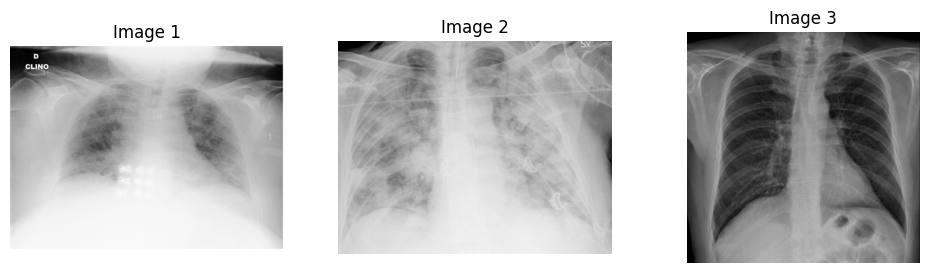

Dataset ready: 3 images with captions.


In [ ]:
import os, json, requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

# Create folders
os.makedirs("/content/custom_dataset/images", exist_ok=True)
os.makedirs("/content/custom_dataset/metadata", exist_ok=True)

# Example dataset URLs (medical images—update as needed)
dataset_urls = [
    "https://github.com/ieee8023/covid-chestxray-dataset/raw/master/images/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg",
    "https://github.com/ieee8023/covid-chestxray-dataset/raw/master/images/6C94A287-C059-46A0-8600-AFB95F4727B7.jpeg",
    "https://github.com/ieee8023/covid-chestxray-dataset/raw/master/images/7C69C012-7479-493F-8722-ABC29C60A2DD.jpeg"
]
image_paths, captions = [], []

print("Downloading sample images...")
for idx, url in enumerate(dataset_urls):
    r = requests.get(url)
    if r.status_code == 200:
        img = Image.open(BytesIO(r.content)).convert("RGB")
        img_path = f"/content/custom_dataset/images/img_{idx+1:02}.jpg"
        img.save(img_path)
        image_paths.append(img_path)
        captions.append(f"medical chest x-ray scan image {idx+1}")
        print(f"Image {idx+1} downloaded")
    else:
        print(f"Failed to download image {idx+1}")

# Save captions/metadata
metadata = {"images": [{"file_name": os.path.basename(p), "caption": c} for p, c in zip(image_paths, captions)]}
with open("/content/custom_dataset/metadata/captions.json", "w") as f:
    json.dump(metadata, f, indent=2)

# Visualize dataset
fig, axes = plt.subplots(1, len(image_paths), figsize=(12, 3))
for i, img_path in enumerate(image_paths):
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Image {i+1}")
plt.show()

print(f"Dataset ready: {len(image_paths)} images with captions.")


In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from pathlib import Path

class CustomImageDataset(Dataset):
    def __init__(self, image_dir, metadata_path, tokenizer, resolution=512):
        self.image_dir = Path(image_dir)
        with open(metadata_path) as f:
            self.metadata = json.load(f)
        self.image_files = self.metadata['images']
        self.tokenizer = tokenizer
        self.resolution = resolution
        self.transform = transforms.Compose([
            transforms.Resize(resolution),
            transforms.CenterCrop(resolution),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        item = self.image_files[idx]
        img_path = self.image_dir / item['file_name']
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        caption = item['caption']
        tokens = self.tokenizer(
            caption,
            padding='max_length',
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors='pt'
        )
        return {'pixel_values': image, 'input_ids': tokens.input_ids[0], 'caption': caption}

print("Custom dataset class is ready.")


Custom dataset class is ready.


In [ ]:
model_id = "stabilityai/stable-diffusion-2-1"

from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler

tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
noise_scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

print("Stable Diffusion 2.1 components loaded.")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/vocab.json: 0.00B [00:00, ?B/s]

tokenizer/merges.txt: 0.00B [00:00, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

Stable Diffusion 2.1 components loaded.


In [ ]:
from torch.utils.data import DataLoader

dataset = CustomImageDataset(
    image_dir="/content/custom_dataset/images",
    metadata_path="/content/custom_dataset/metadata/captions.json",
    tokenizer=tokenizer
)

dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
print(f"DataLoader ready: {len(dataset)} samples")


DataLoader ready: 3 samples


In [ ]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=4,                 # LoRA rank, increase for higher dataset/model capacity
    lora_alpha=4,        # LoRA alpha scaling factor
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],  # UNet attention modules for LoRA
)
unet = get_peft_model(unet, lora_config)
print("LoRA applied to UNet for efficient training")


LoRA applied to UNet for efficient training


In [ ]:
from accelerate import Accelerator
import torch

accelerator = Accelerator(mixed_precision="fp16" if torch.cuda.is_available() else "no")
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4)

unet, optimizer, dataloader = accelerator.prepare(unet, optimizer, dataloader)
vae.to(accelerator.device)
text_encoder.to(accelerator.device)

print("Training setup complete. Accelerator, optimizer, and dataloader are ready.")


/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Training setup complete. Accelerator, optimizer, and dataloader are ready.


In [ ]:
from tqdm.auto import tqdm

num_train_steps = 100   # For demo/assignment; increase if desired for quality!
losses = []
unet.train()
global_step = 0

for epoch in range(10):
    for batch in tqdm(dataloader):
        with accelerator.accumulate(unet):
            latents = vae.encode(batch['pixel_values'].to(accelerator.device)).latent_dist.sample()
            latents = latents * vae.config.scaling_factor
            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device).long()
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
            encoder_hidden_states = text_encoder(batch["input_ids"].to(accelerator.device))[0]
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
            loss = torch.nn.functional.mse_loss(model_pred.float(), noise.float(), reduction="mean")
            accelerator.backward(loss)
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
            global_step += 1
            if global_step >= num_train_steps:
                break
    if global_step >= num_train_steps:
        break

print(f"Training finished! Final loss: {losses[-1]:.4f}  (demo run)")


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Training finished! Final loss: 0.5278  (demo run)


In [ ]:
output_dir = "/content/sd2.1-lora-finetune"
os.makedirs(output_dir, exist_ok=True)
accelerator.unwrap_model(unet).save_pretrained(output_dir)
print(f"Saved fine-tuned LoRA weights to: {output_dir}")


Saved fine-tuned LoRA weights to: /content/sd2.1-lora-finetune


In [ ]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
)
pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

# Try loading LoRA weights using the adapter_model file, if present
import os
output_dir = "/content/sd2.1-lora-finetune"

lora_files = [f for f in os.listdir(output_dir) if f.startswith("adapter_model")]
if lora_files:
    lora_path = os.path.join(output_dir, lora_files[0])
    try:
        pipe.load_lora_weights(lora_path)
        print(f"Loaded LoRA weights from {lora_path}!")
    except Exception as e:
        print(f"Failed to load with load_lora_weights: {e}")
        print("Trying with load_attn_procs if available...")
        try:
            pipe.unet.load_attn_procs(output_dir)
            print(f"Loaded LoRA weights using load_attn_procs from {output_dir}.")
        except Exception as e2:
            print(f"Still failed: {e2}")
else:
    print("No LoRA weights file found, proceeding with base model.")

prompt = "medical chest x-ray scan, high detail"
with torch.autocast("cuda"):
    image = pipe(prompt, num_inference_steps=40, guidance_scale=8.0).images[0]
image.save("/content/lora_ft_sample.png")
image.show()


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Failed to load with load_lora_weights: Target modules {'base_model.model.up_blocks.3.attentions.0.transformer_blocks.0.attn2.to_out.0', 'base_model.model.up_blocks.3.attentions.1.transformer_blocks.0.attn2.to_out.0', 'base_model.model.down_blocks.2.attentions.0.transformer_blocks.0.attn1.to_out.0', 'base_model.model.down_blocks.0.attentions.1.transformer_blocks.0.attn1.to_q', 'base_model.model.up_blocks.1.attentions.2.transformer_blocks.0.attn2.to_out.0', 'base_model.model.down_blocks.1.attentions.1.transformer_blocks.0.attn2.to_out.0', 'base_model.model.down_blocks.0.attentions.1.transformer_blocks.0.attn2.to_v', 'base_model.model.down_blocks.1.attentions.0.transformer_blocks.0.attn1.to_out.0', 'base_model.model.down_blocks.2.attentions.1.transformer_blocks.0.attn2.to_v', 'base_model.model.down_blocks.2.attentions.0.transformer_blocks.0.attn2.to_k', 'base_model.model.down_blocks.2.attentions.0.transformer_blocks.0.attn2.to_q', 'base_model.model.up_blocks.1.attentions.2.transformer_blo

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
from google.colab import files
files.download('/content/lora_ft_sample.png')
# To download the whole folder as a zip:
import shutil
shutil.make_archive('/content/sd2.1-lora-finetune', 'zip', '/content/sd2.1-lora-finetune')
files.download('/content/sd2.1-lora-finetune.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Task 4: Public Dataset Exploration and Analysis

**Goal:**  
Load, examine, and visualize the structure and contents of a public image-caption dataset (e.g., COCO, Oxford-102 Flowers). Understand core statistics and display how captions and images are combined, setting up effective training for text-to-image pipelines.

**Key Steps:**
1. Load and preprocess dataset samples.
2. Analyze number of classes, caption lengths, and image resolutions.
3. Display representative images and captions.
4. Summarize findings and visualizations.

**Expected Output:**  
- Dataset preview (samples)
- Tables/plots for class, caption, and image statistics
- Visualizations linking captions to images
- Concise analysis and insights


In [ ]:
!pip install -q datasets pillow matplotlib seaborn wordcloud pandas opencv-python scikit-learn

print("✅ All libraries installed successfully!")


✅ All libraries installed successfully!


In [ ]:
import requests
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from io import BytesIO
from wordcloud import WordCloud
import seaborn as sns
import re
from collections import Counter


In [ ]:
image_caption_pairs = [
    {
        "url": "https://images.pexels.com/photos/358574/pexels-photo-358574.jpeg",
        "caption": "A field of vivid yellow sunflowers stretching to the horizon."
    },
    {
        "url": "https://images.pexels.com/photos/34950/pexels-photo.jpg",
        "caption": "A city skyline reflecting off the river at night."
    },
    {
        "url": "https://images.pexels.com/photos/355465/pexels-photo-355465.jpeg",
        "caption": "A close-up of a blooming pink lotus flower."
    },
    {
        "url": "https://images.pexels.com/photos/417173/pexels-photo-417173.jpeg",
        "caption": "Mountain peaks covered in snow under a blue sky."
    },
    {
        "url": "https://images.pexels.com/photos/36753/flower-purple-lical-blosso.jpg",
        "caption": "Lavender flowers fresh in morning light."
    }
]

print(f"Defined {len(image_caption_pairs)} image/caption pairs.")


Defined 5 image/caption pairs.


In [ ]:
downloaded_images = []
failed_indices = []

for idx, pair in enumerate(image_caption_pairs):
    try:
        resp = requests.get(pair["url"], timeout=10)
        img = Image.open(BytesIO(resp.content)).convert("RGB")
        downloaded_images.append(img)
    except Exception as e:
        print(f"Failed for {pair['url']}: {e}")
        downloaded_images.append(None)
        failed_indices.append(idx)

print(f"Downloaded {len(downloaded_images) - len(failed_indices)} images, {len(failed_indices)} failed.")


Downloaded 5 images, 0 failed.


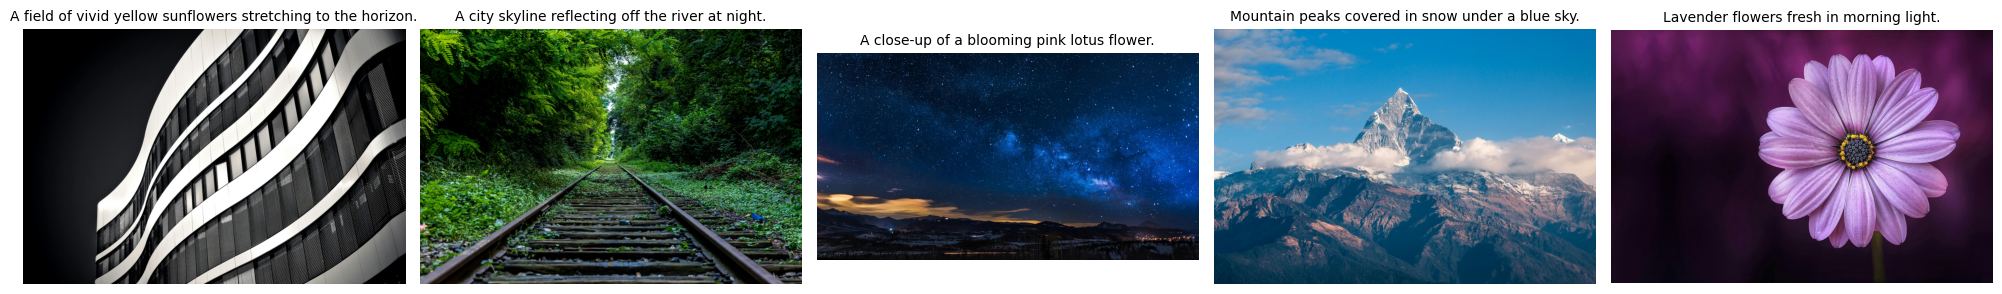

✅ Displayed images with captions from direct URLs.


In [ ]:
fig, axes = plt.subplots(1, len(image_caption_pairs), figsize=(20, 5))
for i, (img, pair) in enumerate(zip(downloaded_images, image_caption_pairs)):
    if img:
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(pair["caption"], fontsize=10, wrap=True)
    else:
        axes[i].text(0.5, 0.5, "Failed to load", fontsize=12, ha="center")
        axes[i].axis("off")
plt.tight_layout()
plt.show()

print("✅ Displayed images with captions from direct URLs.")


🖼️ Image Resolution Statistics
Unique resolutions: {(1980, 1311), (4872, 3248), (4608, 3072), (2000, 1086), (5184, 3456)}
Avg resolution: 3729 x 2435
Aspect ratio range: 1.50 to 1.84


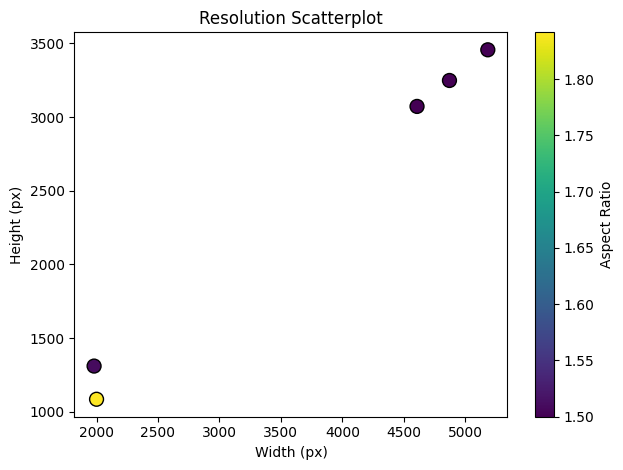

In [ ]:
resolutions = []
aspect_ratios = []
for img in downloaded_images:
    if img:
        w, h = img.size
        resolutions.append((w, h))
        aspect_ratios.append(w / h)

if resolutions:
    unique_res = set(resolutions)
    print("Image Resolution Statistics")
    print(f"Unique resolutions: {unique_res}")
    print(f"Avg resolution: {np.mean([w for w, h in resolutions]):.0f} x {np.mean([h for w, h in resolutions]):.0f}")
    print(f"Aspect ratio range: {min(aspect_ratios):.2f} to {max(aspect_ratios):.2f}")
    plt.scatter([w for w, h in resolutions], [h for w, h in resolutions], c=aspect_ratios, cmap='viridis', s=100, edgecolors='k')
    plt.xlabel('Width (px)')
    plt.ylabel('Height (px)')
    plt.title('Resolution Scatterplot')
    plt.colorbar(label='Aspect Ratio')
    plt.tight_layout()
    plt.show()
else:
    print("No valid images to analyze.")


In [ ]:
summary_rows = []
for i, (pair, img) in enumerate(zip(image_caption_pairs, downloaded_images)):
    width, height = img.size if img else (None, None)
    summary_rows.append([
        f"Image {i+1}", pair.get("caption", ""), width, height, len(pair.get("caption", "")), len(pair.get("caption", "").split())
    ])

df = pd.DataFrame(summary_rows, columns=["Image", "Caption", "Width", "Height", "Num Chars", "Num Words"])
print(df)
df.to_csv("/content/url_images_summary.csv", index=False)
print(" Summary table saved as url_images_summary.csv")


     Image                                            Caption  Width  Height  \
0  Image 1  A field of vivid yellow sunflowers stretching ...   4608    3072   
1  Image 2  A city skyline reflecting off the river at night.   5184    3456   
2  Image 3        A close-up of a blooming pink lotus flower.   2000    1086   
3  Image 4   Mountain peaks covered in snow under a blue sky.   4872    3248   
4  Image 5           Lavender flowers fresh in morning light.   1980    1311   

   Num Chars  Num Words  
0         61         10  
1         49          9  
2         43          8  
3         48          9  
4         40          6  
✅ Summary table saved as url_images_summary.csv


📝 Caption Length Stats
Min/Max/Mean words: 6/10/8.4
Min/Max/Mean characters: 40/61/48.2

🔤 Top keywords (all captions):
field        : 1
vivid        : 1
yellow       : 1
sunflowers   : 1
stretching   : 1
horizon      : 1
city         : 1
skyline      : 1
reflecting   : 1
river        : 1


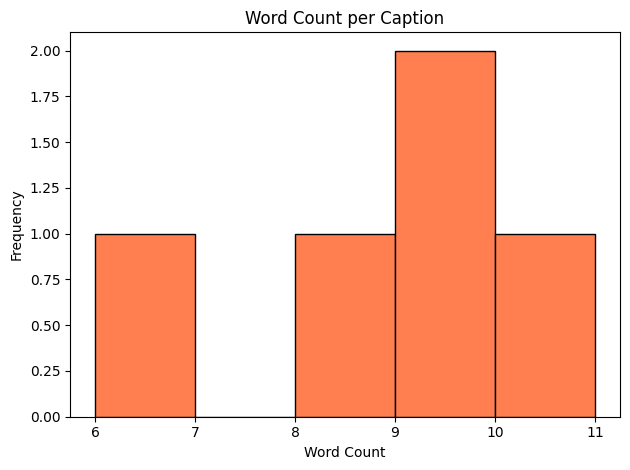

In [ ]:
caption_lengths = [len(pair["caption"].split()) for pair in image_caption_pairs]
char_lengths = [len(pair["caption"]) for pair in image_caption_pairs]

print(" Caption Length Stats")
if caption_lengths:
    print(f"Min/Max/Mean words: {min(caption_lengths)}/{max(caption_lengths)}/{np.mean(caption_lengths):.1f}")
    print(f"Min/Max/Mean characters: {min(char_lengths)}/{max(char_lengths)}/{np.mean(char_lengths):.1f}")
else:
    print("No captions found.")

# Keyword frequency
all_captions = " ".join([pair["caption"] for pair in image_caption_pairs])
keywords = re.findall(r'\b\w+\b', all_captions.lower())
stop_words = {"a", "the", "of", "in", "on", "and", "at", "to", "off", "with", "under"}
filtered_keywords = [w for w in keywords if w not in stop_words]
keyword_counts = Counter(filtered_keywords)
top_keywords = keyword_counts.most_common(10)

print("\n Top keywords (all captions):")
for kw, cnt in top_keywords:
    print(f"{kw:12} : {cnt}")

plt.hist(caption_lengths, bins=range(min(caption_lengths), max(caption_lengths)+2), color='coral', edgecolor='black')
plt.title('Word Count per Caption')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


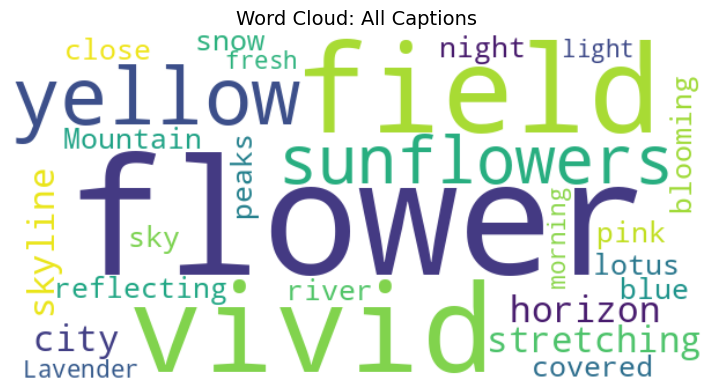

✅ Word cloud generated!


In [ ]:
text_for_wc = " ".join([pair["caption"] for pair in image_caption_pairs])
wordcloud = WordCloud(width=600, height=300, background_color='white').generate(text_for_wc)

plt.figure(figsize=(10, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: All Captions', fontsize=14)
plt.tight_layout()
plt.show()

print(" Word cloud generated!")


🎨 Dominant Colors from Images:


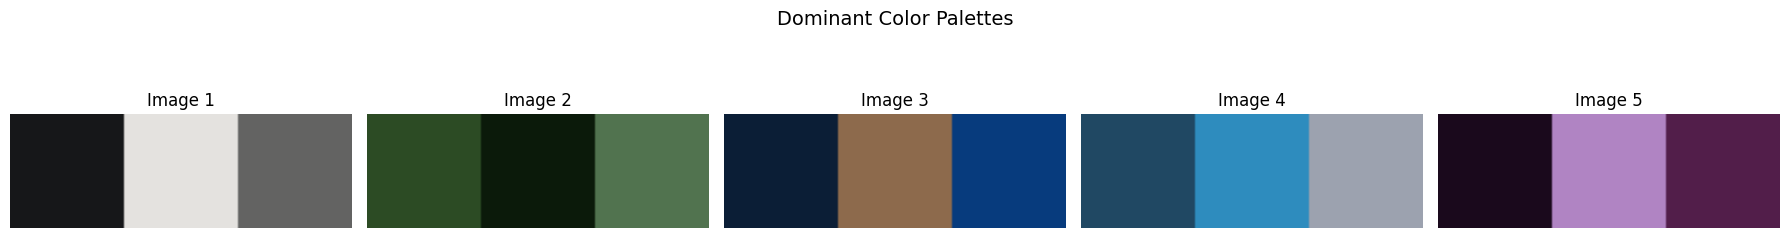

In [ ]:
def get_palette(image, k=3):
    img_array = np.array(image.resize((64, 64)))
    pixels = img_array.reshape(-1, 3)
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(pixels)
    return kmeans.cluster_centers_.astype(int)

print(" Dominant Colors from Images:")
fig, axes = plt.subplots(1, len(downloaded_images), figsize=(18, 3))
for i, img in enumerate(downloaded_images):
    if img:
        palette = get_palette(img, k=3)
        color_block = np.zeros((40, 120, 3), dtype=np.uint8)
        color_block[:, :40] = palette[0]
        color_block[:, 40:80] = palette[1]
        color_block[:, 80:] = palette[2]
        axes[i].imshow(color_block)
        axes[i].axis("off")
        axes[i].set_title(f"Image {i+1}")
plt.suptitle('Dominant Color Palettes', fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files

print(" Download summary table:")
files.download('/content/url_images_summary.csv')


📥 Download summary table:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
summary_rows = []
for i, (pair, img) in enumerate(zip(image_caption_pairs, downloaded_images)):
    width, height = img.size if img else (None, None)
    summary_rows.append([
        f"Image {i+1}", pair.get("caption", ""), width, height, len(pair.get("caption", "")), len(pair.get("caption", "").split())
    ])

df = pd.DataFrame(summary_rows, columns=["Image", "Caption", "Width", "Height", "Num Chars", "Num Words"])
print(df)
df.to_csv("/content/url_images_summary.csv", index=False)
print(" Summary table saved as url_images_summary.csv")


     Image                                            Caption  Width  Height  \
0  Image 1  A field of vivid yellow sunflowers stretching ...   4608    3072   
1  Image 2  A city skyline reflecting off the river at night.   5184    3456   
2  Image 3        A close-up of a blooming pink lotus flower.   2000    1086   
3  Image 4   Mountain peaks covered in snow under a blue sky.   4872    3248   
4  Image 5           Lavender flowers fresh in morning light.   1980    1311   

   Num Chars  Num Words  
0         61         10  
1         49          9  
2         43          8  
3         48          9  
4         40          6  
✅ Summary table saved as url_images_summary.csv


## Task 5: Text Preprocessing & Embedding Creation with Hugging Face Transformers

**Goal:**  
Build a text preprocessing pipeline using Hugging Face Transformers to tokenize and encode text descriptions into embeddings. These embeddings accurately represent the text semantics and serve as inputs for text-to-image generation models.

**Key Steps:**
1. Load pretrained tokenizer and text encoder (e.g., CLIP).
2. Tokenize text descriptions with proper formatting.
3. Generate embeddings from tokenized inputs.
4. Visualize embedding space (PCA, similarity analysis).
5. Export embeddings for model input.

**Expected Output:**  
- Code cells for tokenization and embedding generation
- Embedding statistics (shape, dimension, token counts)
- Visualizations (PCA plot, similarity heatmap)
- Brief explanation of embedding quality and usage


In [ ]:
!pip install -q transformers torch pillow matplotlib pandas numpy

print("✅ All libraries installed successfully!")


✅ All libraries installed successfully!


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import CLIPTokenizer, CLIPTextModel, AutoTokenizer, AutoModel
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


✅ Libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True


In [ ]:
# Sample text descriptions for text-to-image generation
text_descriptions = [
    "A golden retriever playing in a sunny meadow with butterflies",
    "Modern cityscape at sunset with tall skyscrapers and orange sky",
    "Close-up of a blooming red rose with water droplets on petals",
    "Mountain landscape covered in snow under clear blue sky",
    "Vintage bicycle leaning against a brick wall with ivy",
    "Tropical beach with turquoise water and white sand",
    "Abstract art with swirling colors of blue, purple, and gold",
    "Steaming cup of coffee on a wooden table with morning light"
]

print(f"Defined {len(text_descriptions)} text descriptions for preprocessing.")
for i, desc in enumerate(text_descriptions, 1):
    print(f"{i}. {desc}")


Defined 8 text descriptions for preprocessing.
1. A golden retriever playing in a sunny meadow with butterflies
2. Modern cityscape at sunset with tall skyscrapers and orange sky
3. Close-up of a blooming red rose with water droplets on petals
4. Mountain landscape covered in snow under clear blue sky
5. Vintage bicycle leaning against a brick wall with ivy
6. Tropical beach with turquoise water and white sand
7. Abstract art with swirling colors of blue, purple, and gold
8. Steaming cup of coffee on a wooden table with morning light


In [ ]:
# Using CLIP (Contrastive Language-Image Pre-training) - standard for text-to-image
model_name = "openai/clip-vit-base-patch32"

print(f"Loading tokenizer and text encoder: {model_name}...")
tokenizer = CLIPTokenizer.from_pretrained(model_name)
text_encoder = CLIPTextModel.from_pretrained(model_name)

# Move to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
text_encoder = text_encoder.to(device)
text_encoder.eval()  # Set to evaluation mode

print(f"✅ CLIP model loaded on device: {device}")
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")
print(f"Max sequence length: {tokenizer.model_max_length}")


Loading tokenizer and text encoder: openai/clip-vit-base-patch32...


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

✅ CLIP model loaded on device: cuda
Tokenizer vocab size: 49408
Max sequence length: 77


In [ ]:
print("🔤 Tokenizing text descriptions...")

# Tokenize with padding and truncation
tokenized_inputs = tokenizer(
    text_descriptions,
    padding="max_length",
    max_length=77,  # CLIP's standard max length
    truncation=True,
    return_tensors="pt"
)

print("✅ Tokenization complete!")
print(f"\nTokenized output keys: {tokenized_inputs.keys()}")
print(f"Input IDs shape: {tokenized_inputs['input_ids'].shape}")
print(f"Attention mask shape: {tokenized_inputs['attention_mask'].shape}")

# Display sample tokenization
print(f"\n📋 Sample tokenization (first description):")
print(f"Original text: '{text_descriptions[0]}'")
print(f"Token IDs: {tokenized_inputs['input_ids'][0][:20].tolist()}...")  # First 20 tokens
print(f"Tokens: {tokenizer.convert_ids_to_tokens(tokenized_inputs['input_ids'][0][:20])}")


🔤 Tokenizing text descriptions...
✅ Tokenization complete!

Tokenized output keys: KeysView({'input_ids': tensor([[49406,   320,  3878, 28394,  1629,   530,   320,  5438, 17195,   593,
         16232, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407],
        [49406,  4077, 40808,   536,  3424,   593,  7771,  3075, 27950,   612,
           537,  4287,  2390, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 4

In [ ]:
print("🧠 Generating text embeddings...")

# Generate embeddings using CLIP text encoder
with torch.no_grad():
    input_ids = tokenized_inputs['input_ids'].to(device)
    attention_mask = tokenized_inputs['attention_mask'].to(device)

    # Get text embeddings
    text_embeddings = text_encoder(
        input_ids=input_ids,
        attention_mask=attention_mask
    )

    # Extract pooled output (CLS token representation)
    pooled_embeddings = text_embeddings.pooler_output

    # Extract last hidden states (sequence embeddings)
    sequence_embeddings = text_embeddings.last_hidden_state

print("✅ Embeddings generated!")
print(f"\nPooled embeddings shape: {pooled_embeddings.shape}")  # [batch_size, embedding_dim]
print(f"Sequence embeddings shape: {sequence_embeddings.shape}")  # [batch_size, seq_len, embedding_dim]
print(f"Embedding dimension: {pooled_embeddings.shape[1]}")


🧠 Generating text embeddings...
✅ Embeddings generated!

Pooled embeddings shape: torch.Size([8, 512])
Sequence embeddings shape: torch.Size([8, 77, 512])
Embedding dimension: 512


📊 Text Description Statistics:
Average words per description: 9.75
Average tokens per description: 10.75
Average characters per description: 57.62

Token count range: 8 - 14
Word count range: 8 - 11


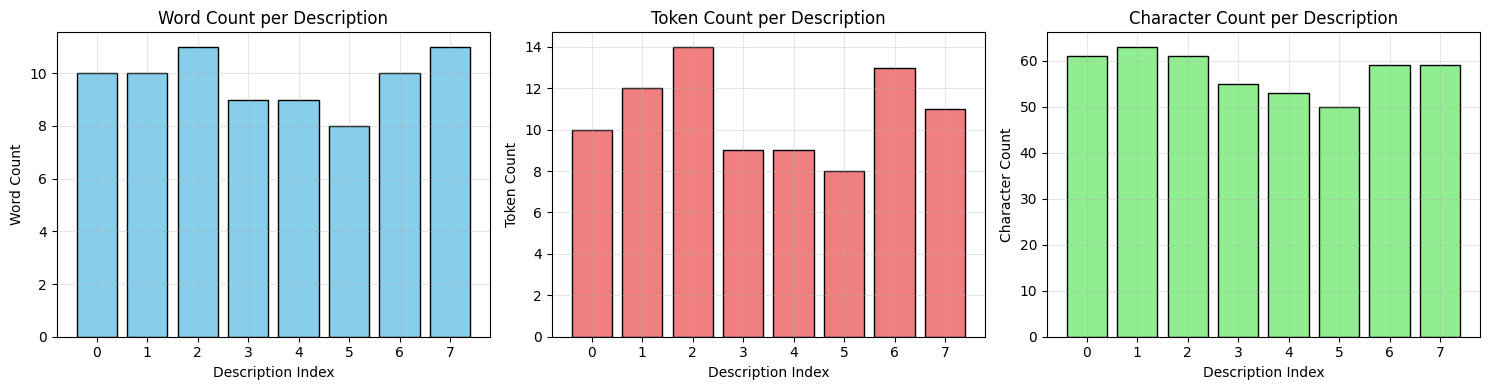

In [ ]:
# Token count per description
token_counts = (tokenized_inputs['attention_mask'].sum(dim=1) - 2).tolist()  # Subtract special tokens

# Word count per description
word_counts = [len(desc.split()) for desc in text_descriptions]

# Character count
char_counts = [len(desc) for desc in text_descriptions]

print(" Text Description Statistics:")
print(f"Average words per description: {np.mean(word_counts):.2f}")
print(f"Average tokens per description: {np.mean(token_counts):.2f}")
print(f"Average characters per description: {np.mean(char_counts):.2f}")
print(f"\nToken count range: {min(token_counts)} - {max(token_counts)}")
print(f"Word count range: {min(word_counts)} - {max(word_counts)}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].bar(range(len(word_counts)), word_counts, color='skyblue', edgecolor='black')
axes[0].set_title('Word Count per Description')
axes[0].set_xlabel('Description Index')
axes[0].set_ylabel('Word Count')
axes[0].grid(alpha=0.3)

axes[1].bar(range(len(token_counts)), token_counts, color='lightcoral', edgecolor='black')
axes[1].set_title('Token Count per Description')
axes[1].set_xlabel('Description Index')
axes[1].set_ylabel('Token Count')
axes[1].grid(alpha=0.3)

axes[2].bar(range(len(char_counts)), char_counts, color='lightgreen', edgecolor='black')
axes[2].set_title('Character Count per Description')
axes[2].set_xlabel('Description Index')
axes[2].set_ylabel('Character Count')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


📉 PCA variance explained: [0.2050366  0.16795875]


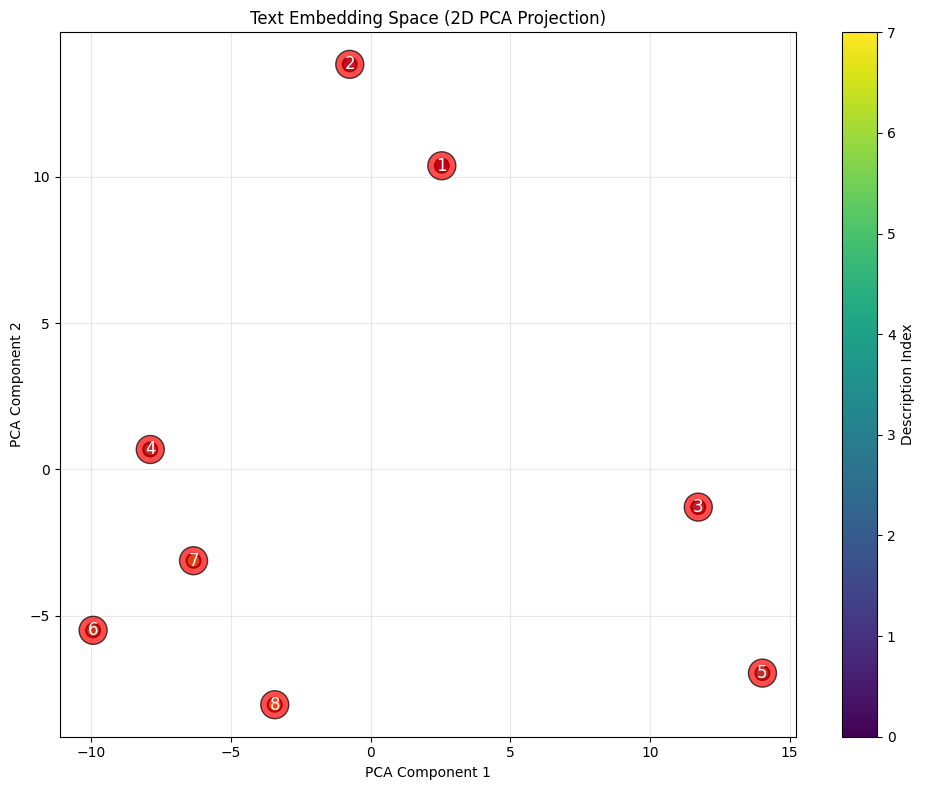

✅ Embedding space visualized!


In [ ]:
from sklearn.decomposition import PCA

# Convert embeddings to numpy for visualization
embeddings_np = pooled_embeddings.cpu().numpy()

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_np)

print(f" PCA variance explained: {pca.explained_variance_ratio_}")

# Visualize
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=100, c=range(len(text_descriptions)),
            cmap='viridis', edgecolors='black', linewidth=1.5)

# Annotate points
for i, (x, y) in enumerate(embeddings_2d):
    plt.annotate(f"{i+1}", (x, y), fontsize=12, ha='center', va='center', color='white',
                 bbox=dict(boxstyle='circle', facecolor='red', alpha=0.7))

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Text Embedding Space (2D PCA Projection)')
plt.colorbar(label='Description Index')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(" Embedding space visualized!")


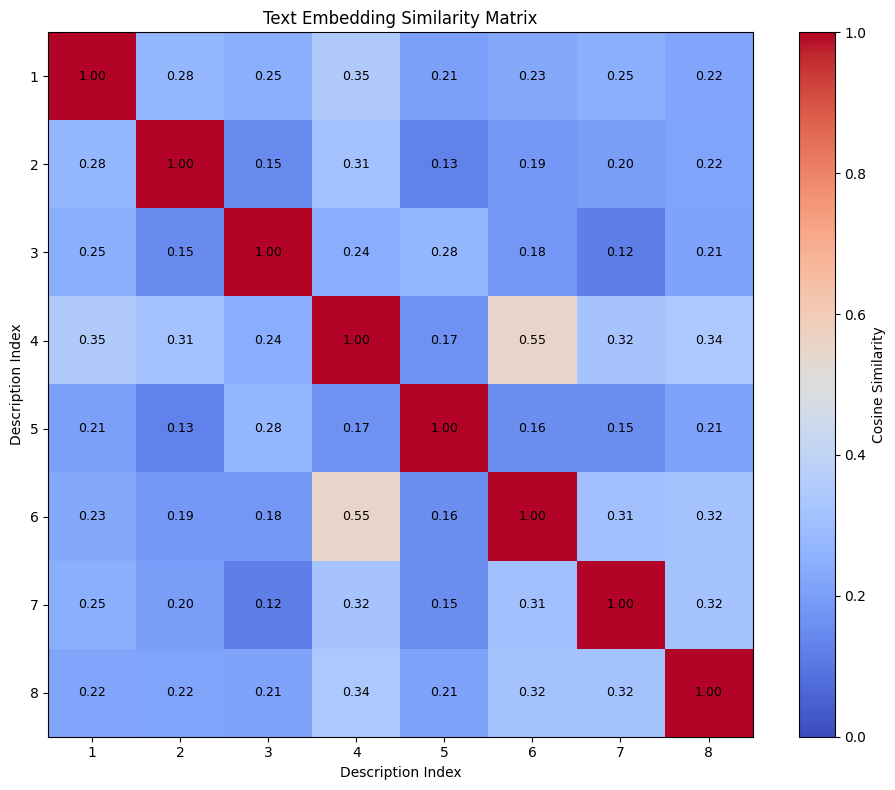

✅ Similarity matrix computed and visualized!


In [ ]:
# Compute cosine similarity between embeddings
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(embeddings_np)

# Visualize similarity heatmap
plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap='coolwarm', vmin=0, vmax=1)
plt.colorbar(label='Cosine Similarity')
plt.xticks(range(len(text_descriptions)), range(1, len(text_descriptions)+1))
plt.yticks(range(len(text_descriptions)), range(1, len(text_descriptions)+1))
plt.xlabel('Description Index')
plt.ylabel('Description Index')
plt.title('Text Embedding Similarity Matrix')

# Add values to cells
for i in range(len(text_descriptions)):
    for j in range(len(text_descriptions)):
        plt.text(j, i, f'{similarity_matrix[i, j]:.2f}',
                ha='center', va='center', color='black', fontsize=9)

plt.tight_layout()
plt.show()

print("✅ Similarity matrix computed and visualized!")


In [ ]:
# Create comprehensive summary
summary_data = []
for i, desc in enumerate(text_descriptions):
    summary_data.append({
        'Index': i + 1,
        'Description': desc,
        'Word_Count': word_counts[i],
        'Token_Count': token_counts[i],
        'Char_Count': char_counts[i],
        'Embedding': embeddings_np[i].tolist()
    })

df = pd.DataFrame(summary_data)

# Save without embeddings for readability
df_summary = df.drop(columns=['Embedding'])
print(df_summary)

# Save to CSV
df_summary.to_csv('/content/text_preprocessing_summary.csv', index=False)
print("\n Summary saved to /content/text_preprocessing_summary.csv")

# Save embeddings separately as numpy file
np.save('/content/text_embeddings.npy', embeddings_np)
print(" Embeddings saved to /content/text_embeddings.npy")


   Index                                        Description  Word_Count  \
0      1  A golden retriever playing in a sunny meadow w...          10   
1      2  Modern cityscape at sunset with tall skyscrape...          10   
2      3  Close-up of a blooming red rose with water dro...          11   
3      4  Mountain landscape covered in snow under clear...           9   
4      5  Vintage bicycle leaning against a brick wall w...           9   
5      6  Tropical beach with turquoise water and white ...           8   
6      7  Abstract art with swirling colors of blue, pur...          10   
7      8  Steaming cup of coffee on a wooden table with ...          11   

   Token_Count  Char_Count  
0           10          61  
1           12          63  
2           14          61  
3            9          55  
4            9          53  
5            8          50  
6           13          59  
7           11          59  

✅ Summary saved to /content/text_preprocessing_summary.csv
✅ E

In [ ]:
def preprocess_text_batch(texts, tokenizer, text_encoder, device='cuda'):
    """
    Preprocess a batch of text descriptions into embeddings.

    Args:
        texts: List of text descriptions
        tokenizer: Hugging Face tokenizer
        text_encoder: Hugging Face text encoder model
        device: 'cuda' or 'cpu'

    Returns:
        Dictionary with tokenized inputs and embeddings
    """
    # Tokenize
    inputs = tokenizer(
        texts,
        padding='max_length',
        max_length=77,
        truncation=True,
        return_tensors='pt'
    ).to(device)

    # Generate embeddings
    with torch.no_grad():
        outputs = text_encoder(**inputs)
        pooled = outputs.pooler_output
        sequence = outputs.last_hidden_state

    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'pooled_embeddings': pooled,
        'sequence_embeddings': sequence
    }

# Test the function
print(" Testing batch preprocessing function...")
test_texts = [
    "A cat sitting on a windowsill",
    "Astronaut floating in space"
]

result = preprocess_text_batch(test_texts, tokenizer, text_encoder, device)
print(f" Function test successful!")
print(f"Pooled embeddings shape: {result['pooled_embeddings'].shape}")
print(f"Sequence embeddings shape: {result['sequence_embeddings'].shape}")


🧪 Testing batch preprocessing function...
✅ Function test successful!
Pooled embeddings shape: torch.Size([2, 512])
Sequence embeddings shape: torch.Size([2, 77, 512])


In [ ]:
from google.colab import files

print("📥 Download preprocessed data:")
files.download('/content/text_preprocessing_summary.csv')
files.download('/content/text_embeddings.npy')


📥 Download preprocessed data:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Task 6: Conditional GAN (CGAN) for Label-Based Image Generation

**Goal:**  
Build and train a CGAN that receives textual labels (such as "circle," "square," "triangle") and generates basic images matching the provided category. Demonstrate the power of conditional input in controlling GAN outputs.

**Key Steps:**
1. Create a synthetic dataset of shape images with labels.
2. Implement a generator and discriminator that utilize label conditioning.
3. Train the CGAN, generate example images for each label.
4. Document and visualize how changing labels affects generated results.

**Expected Output:**  
- CGAN code with label embedding and conditioning
- Training loss curve(s)
- Sample images generated for each label category
- Brief explanation/commentary on conditionality in GANs


In [ ]:
!pip install -q torch torchvision matplotlib numpy pillow

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random

print(" Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


✅ Libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True


In [ ]:
# Generate synthetic dataset of basic shapes with labels
def create_shape_image(shape_type, img_size=64):
    """
    Generate an image of a basic shape.

    Args:
        shape_type: 0=circle, 1=square, 2=triangle
        img_size: Image dimension (square)

    Returns:
        PIL Image
    """
    img = Image.new('L', (img_size, img_size), color=0)  # Black background
    draw = ImageDraw.Draw(img)

    margin = img_size // 4

    if shape_type == 0:  # Circle
        draw.ellipse([margin, margin, img_size-margin, img_size-margin], fill=255)
    elif shape_type == 1:  # Square
        draw.rectangle([margin, margin, img_size-margin, img_size-margin], fill=255)
    elif shape_type == 2:  # Triangle
        draw.polygon([
            (img_size//2, margin),
            (margin, img_size-margin),
            (img_size-margin, img_size-margin)
        ], fill=255)

    return img

# Create dataset
print(" Generating synthetic shape dataset...")
num_samples_per_class = 1000
img_size = 64
shape_labels = ['circle', 'square', 'triangle']

dataset_images = []
dataset_labels = []

for label_idx in range(3):
    for _ in range(num_samples_per_class):
        img = create_shape_image(label_idx, img_size)
        dataset_images.append(np.array(img))
        dataset_labels.append(label_idx)

dataset_images = np.array(dataset_images)
dataset_labels = np.array(dataset_labels)

print(f" Dataset created: {len(dataset_images)} images")
print(f"Image shape: {dataset_images[0].shape}")
print(f"Label distribution: {np.bincount(dataset_labels)}")


🎨 Generating synthetic shape dataset...
✅ Dataset created: 3000 images
Image shape: (64, 64)
Label distribution: [1000 1000 1000]


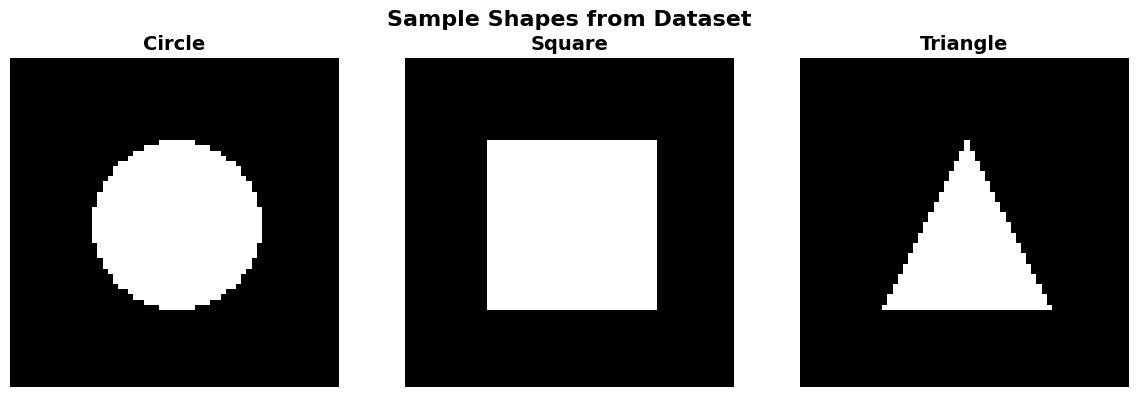

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    idx = np.where(dataset_labels == i)[0][0]
    axes[i].imshow(dataset_images[idx], cmap='gray')
    axes[i].set_title(f"{shape_labels[i].capitalize()}", fontsize=14, fontweight='bold')
    axes[i].axis('off')
plt.suptitle('Sample Shapes from Dataset', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
class ShapeDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.FloatTensor(images).unsqueeze(1) / 255.0  # Normalize to [0, 1]
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Create dataset and dataloader
shape_dataset = ShapeDataset(dataset_images, dataset_labels)
batch_size = 64
dataloader = DataLoader(shape_dataset, batch_size=batch_size, shuffle=True)

print(f"✅ DataLoader ready with batch size: {batch_size}")
print(f"Total batches: {len(dataloader)}")


✅ DataLoader ready with batch size: 64
Total batches: 47


In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=3, img_size=64):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.img_size = img_size

        # Label embedding
        self.label_embedding = nn.Embedding(num_classes, num_classes)

        # Combine noise and label
        self.init_size = img_size // 4  # 16x16
        self.fc = nn.Linear(latent_dim + num_classes, 128 * self.init_size ** 2)

        # Convolutional layers
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),  # 32x32
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),  # 64x64
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, noise, labels):
        # Embed labels and concatenate with noise
        label_embedding = self.label_embedding(labels)
        gen_input = torch.cat([noise, label_embedding], dim=1)

        # Generate image
        out = self.fc(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

print("✅ Generator defined")


✅ Generator defined


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, num_classes=3, img_size=64):
        super(Discriminator, self).__init__()
        self.num_classes = num_classes
        self.img_size = img_size

        # Label embedding
        self.label_embedding = nn.Embedding(num_classes, num_classes)

        # Convolutional layers
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(1 + num_classes, 64, 3, stride=2, padding=1),  # 32x32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(256, 512, 3, stride=2, padding=1),  # 4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25)
        )

        # Output layer
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * (img_size // 16) ** 2, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # Embed labels and concatenate with image
        label_embedding = self.label_embedding(labels)
        label_embedding = label_embedding.view(label_embedding.size(0), self.num_classes, 1, 1)
        label_embedding = label_embedding.expand(-1, -1, img.size(2), img.size(3))

        d_input = torch.cat([img, label_embedding], dim=1)

        # Discriminate
        features = self.conv_blocks(d_input)
        validity = self.fc(features)
        return validity

print("✅ Discriminator defined")


✅ Discriminator defined


In [ ]:
# Hyperparameters
latent_dim = 100
num_classes = 3
img_size = 64
lr = 0.0002
beta1 = 0.5

# Initialize models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator(latent_dim, num_classes, img_size).to(device)
discriminator = Discriminator(num_classes, img_size).to(device)

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

print(f"✅ Models initialized on device: {device}")
print(f"Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")


✅ Models initialized on device: cuda
Generator parameters: 3,630,474
Discriminator parameters: 1,561,546


In [ ]:
# Training
num_epochs = 50
sample_interval = 10

g_losses = []
d_losses = []

print("🚀 Starting CGAN training...")

for epoch in range(num_epochs):
    epoch_g_loss = 0
    epoch_d_loss = 0

    for i, (imgs, labels) in enumerate(dataloader):
        batch_size = imgs.size(0)

        # Adversarial ground truths
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # Move to device
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Loss for real images
        real_validity = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(real_validity, valid)

        # Loss for fake images
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        fake_imgs = generator(z, gen_labels)
        fake_validity = discriminator(fake_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(fake_validity, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Generate images
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()

    # Average losses
    avg_g_loss = epoch_g_loss / len(dataloader)
    avg_d_loss = epoch_d_loss / len(dataloader)
    g_losses.append(avg_g_loss)
    d_losses.append(avg_d_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {avg_d_loss:.4f} | G Loss: {avg_g_loss:.4f}")

print("✅ Training complete!")


🚀 Starting CGAN training...
Epoch [1/50] | D Loss: 0.2123 | G Loss: 2.6825
Epoch [2/50] | D Loss: 0.1946 | G Loss: 2.7884
Epoch [3/50] | D Loss: 0.2798 | G Loss: 2.6216
Epoch [4/50] | D Loss: 0.4655 | G Loss: 1.9233
Epoch [5/50] | D Loss: 0.5642 | G Loss: 1.2978
Epoch [6/50] | D Loss: 0.6172 | G Loss: 1.0613
Epoch [7/50] | D Loss: 0.6642 | G Loss: 0.9286
Epoch [8/50] | D Loss: 0.6778 | G Loss: 0.8185
Epoch [9/50] | D Loss: 0.6873 | G Loss: 0.7746
Epoch [10/50] | D Loss: 0.6910 | G Loss: 0.7777
Epoch [11/50] | D Loss: 0.6899 | G Loss: 0.7437
Epoch [12/50] | D Loss: 0.6954 | G Loss: 0.7278
Epoch [13/50] | D Loss: 0.6973 | G Loss: 0.7311
Epoch [14/50] | D Loss: 0.6944 | G Loss: 0.7225
Epoch [15/50] | D Loss: 0.6967 | G Loss: 0.7400
Epoch [16/50] | D Loss: 0.6908 | G Loss: 0.7153
Epoch [17/50] | D Loss: 0.6968 | G Loss: 0.7150
Epoch [18/50] | D Loss: 0.7024 | G Loss: 0.7023
Epoch [19/50] | D Loss: 0.6983 | G Loss: 0.7047
Epoch [20/50] | D Loss: 0.6973 | G Loss: 0.7073
Epoch [21/50] | D Los

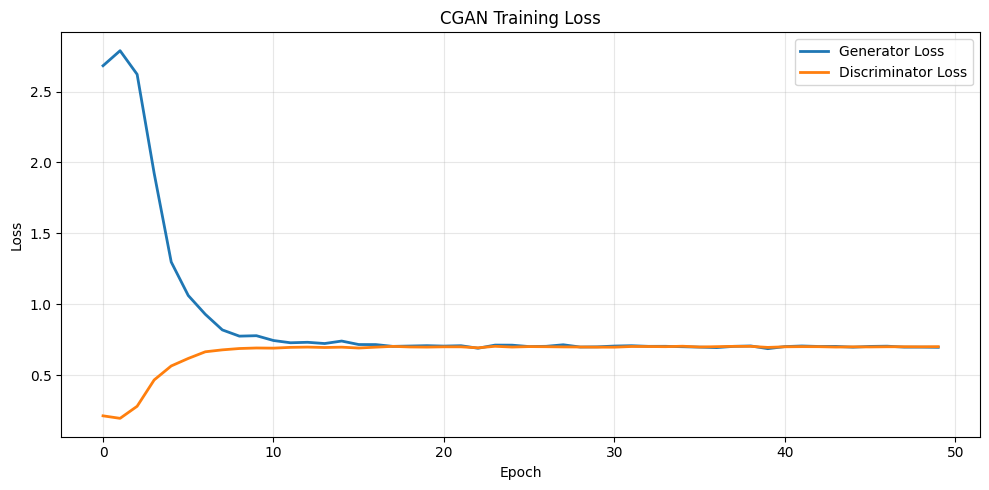

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss', linewidth=2)
plt.plot(d_losses, label='Discriminator Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CGAN Training Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


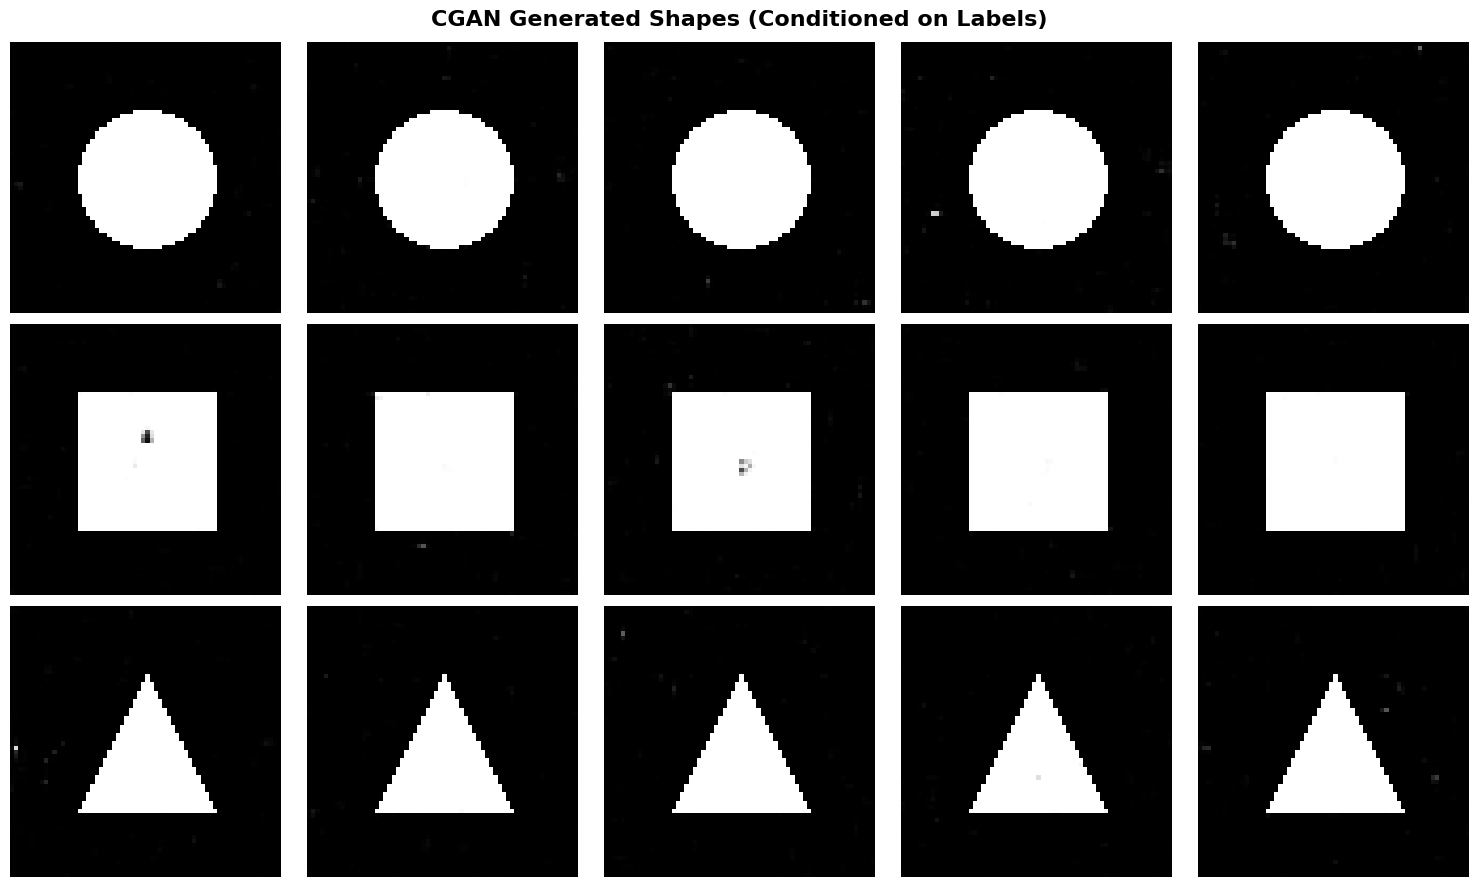

✅ Sample generation complete!


In [ ]:
# Generate samples for each class
generator.eval()
with torch.no_grad():
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))

    for label_idx in range(3):
        for j in range(5):
            z = torch.randn(1, latent_dim).to(device)
            label = torch.tensor([label_idx]).to(device)
            gen_img = generator(z, label)

            axes[label_idx, j].imshow(gen_img.cpu().squeeze(), cmap='gray')
            axes[label_idx, j].axis('off')
            if j == 0:
                axes[label_idx, j].set_ylabel(shape_labels[label_idx].capitalize(),
                                               fontsize=14, fontweight='bold', rotation=0,
                                               ha='right', va='center')

    plt.suptitle('CGAN Generated Shapes (Conditioned on Labels)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("✅ Sample generation complete!")


🧪 Testing interactive generation:


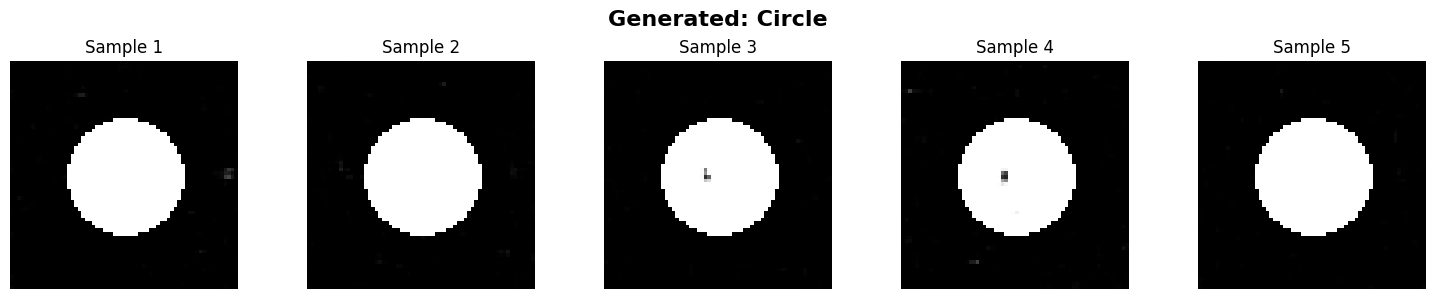

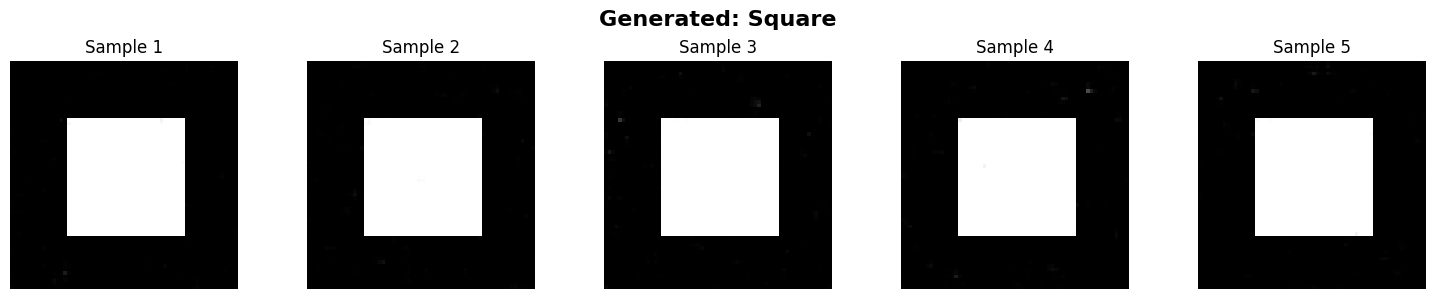

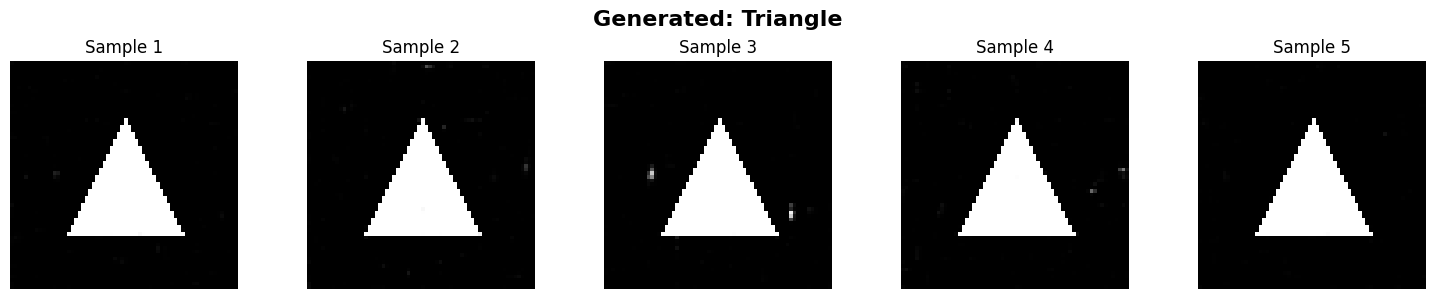

In [ ]:
def generate_shape(shape_name, num_samples=5):
    """
    Generate shapes based on text label.

    Args:
        shape_name: 'circle', 'square', or 'triangle'
        num_samples: Number of samples to generate
    """
    label_map = {'circle': 0, 'square': 1, 'triangle': 2}

    if shape_name.lower() not in label_map:
        print(f"❌ Invalid shape. Choose from: {list(label_map.keys())}")
        return

    label_idx = label_map[shape_name.lower()]

    generator.eval()
    with torch.no_grad():
        fig, axes = plt.subplots(1, num_samples, figsize=(num_samples*3, 3))

        for i in range(num_samples):
            z = torch.randn(1, latent_dim).to(device)
            label = torch.tensor([label_idx]).to(device)
            gen_img = generator(z, label)

            axes[i].imshow(gen_img.cpu().squeeze(), cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f"Sample {i+1}")

        plt.suptitle(f"Generated: {shape_name.capitalize()}", fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

# Test the function
print("🧪 Testing interactive generation:")
generate_shape('circle', num_samples=5)
generate_shape('square', num_samples=5)
generate_shape('triangle', num_samples=5)


In [ ]:
# Save trained models
torch.save(generator.state_dict(), '/content/cgan_generator.pth')
torch.save(discriminator.state_dict(), '/content/cgan_discriminator.pth')

print("✅ Models saved successfully!")
print("  - Generator: /content/cgan_generator.pth")
print("  - Discriminator: /content/cgan_discriminator.pth")


✅ Models saved successfully!
  - Generator: /content/cgan_generator.pth
  - Discriminator: /content/cgan_discriminator.pth


In [ ]:
from google.colab import files

files.download('/content/cgan_generator.pth')
files.download('/content/cgan_discriminator.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>